# Energy Demand Forecasting - Data Load code for DAG

## Packages

In [1]:
# psycopg2: python package to deal with a postgres database
# pip install psycopg2
import psycopg2
from psycopg2.extras import execute_values

In [2]:
import os

import numpy as np
import pandas as pd
import warnings

from datetime import datetime, timedelta
from calendar import monthrange

import requests

from bs4 import BeautifulSoup

import zipfile

# Librería para obtener el usuario que está ejecutando el script
import getpass

import matplotlib.pyplot as plt
%matplotlib inline

import traceback

import hashlib

warnings.filterwarnings("ignore", category=Warning)
# Seteos de Pandas para ver mejor la info. https://pandas.pydata.org/pandas-docs/stable/user_guide/options.html
# In max_columns and max_rows ‘None’ value means unlimited.
pd.set_option('display.max_rows', 100)
# Conviene setear min_rows también porque cuando se superan las max_rows, sólo muestra la cantidad indicada en min_rows.
pd.set_option('display.min_rows', 10)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.max_colwidth = 100
pd.options.display.float_format = '{:.2f}'.format

# Support Functions

In [3]:
def build_postgres_cnxn(database, host, user, password, port=5432, string_connection=None, verbose=True):
    error_txt = ''
    process_ok = True
    cnxn = None
    cursor = None
    if (not host or not user or not password) and not string_connection:
        process_ok = False
        error_txt = 'ERROR build_postgres_cnxn: Error trying to Build DB connexion: you missed to send host, user or password, or string connection. ' +\
                    ' host: ' + (host if host else 'Missed. ') +\
                    ' user: ' + (user if user else 'Missed.') +\
                    ' password: ' + (password if password else 'Missed.') +\
                    ' String Connection: ' + (string_connection if string_connection else 'Missed.')
        if verbose:
            print(error_txt)
    else:
        if not database:
            if verbose:
                print('WARNING build_postgres_cnxn: no database name provided.')
        try:
            if not string_connection:
                cnxn = psycopg2.connect(database=database, host=host, user=user, password=password, port=port)
            else:
                cnxn = psycopg2.connect(string_connection)
            cursor = cnxn.cursor()
            if verbose:
                print('INFO Module build_postgres_cnxn: DB Connection to host', host, 'Ok')
        except Exception as err:
            process_ok = False
            formatted_lines = traceback.format_exc().splitlines()
            txt = ' '.join(formatted_lines)
            if not string_connection:
                if verbose:
                    print('ERROR build_postgres_cnxn: Error connectig to database host: ' + host + ' user ' +\
                      user + ' port: ' + str(port) +'\n' + txt)
            else:
                if verbose:
                    print('ERROR build_postgres_cnxn: Error connectig to database string_connection: ' + string_connection +'\n' + txt)
    return process_ok, error_txt, cnxn, cursor

In [4]:
def pg_select_to_pandas(cursor, sql_query, verbose=True):
    error_txt = ''
    process_ok = True
    df = pd.DataFrame()
    if (not cursor or not sql_query):
        process_ok = False
        error_txt = 'ERROR pg_select_to_pandas: No cursor or Query sent as parameter. ' +\
              ' cursor: ' + (' received.' if cursor else ' missed,') +\
              ' query: ' + (sql_query if sql_query else ' missed.')
        if verbose:
            print(error_txt)
    else:
        try:
            cursor.execute(sql_query)
            data = cursor.fetchall()
            colnames = [desc[0] for desc in cursor.description]
            df = pd.DataFrame(data=data, columns=colnames)
            if verbose:
                print('INFO pg_select_to_pandas: query executed Ok. Number of records returned: ' + str(df.shape[0]))
        except Exception as err:
            process_ok = False
            formatted_lines = traceback.format_exc().splitlines()
            txt = ' '.join(formatted_lines)
            error_txt = 'ERROR pg_select_to_pandas: Error executing query on host: ' + cursor.connection.info.host + ' database ' +\
                  cursor.connection.info.dbname + ' query: ' + sql_query +'\n' + txt
            if verbose:
                print(error_txt)
    return process_ok, error_txt, df

In [5]:
def masive_insert(table, df, cursor, cnxn):
    bool_raise = False
    error_txt = ''
    user=getpass.getuser()
    df['create_date'] = datetime.now()
    df['create_user'] = user
    df['update_date'] = datetime.now()
    df['update_user'] = user
    tup = [tuple(r) for r in df.to_numpy()]
        
    cols_to_insert = f'({(", ".join(df.columns.tolist()))})'
        
    sql = "INSERT INTO "+table+" "+cols_to_insert+" VALUES %s"
    try:
        execute_values(cursor, sql, tup)
        cnxn.commit()
        print(f'{df.shape[0]} rows inserted to the {table} table')
    except Exception as err:
        formatted_lines = traceback.format_exc().splitlines()
        txt = ' '.join(formatted_lines)
        bool_raise = True
        error_txt = 'Masive Insert - SQL Insert Error. SQL: ' + '\n' + sql + '\n' + txt
    return bool_raise, error_txt

In [6]:
def download_file(url: str, dest_file: str, dest_folder: str, verbose=True):
    bool_raise = False
    error_txt = ''
    try:
        if not os.path.exists(dest_folder):
            os.makedirs(dest_folder)  # create folder if it does not exist
            #filename = url.replace(" ", "_")  # be careful with file names
        file_path = os.path.join(dest_folder, dest_file)

        r = requests.get(url, stream=True)
        if r.ok:
            if verbose:
                print("saving to", os.path.abspath(file_path))
            with open(file_path, 'wb') as f:
                for chunk in r.iter_content(chunk_size=1024 * 8):
                    if chunk:
                        f.write(chunk)
                        f.flush()
                        os.fsync(f.fileno())
        else:  # HTTP status code 4XX/5XX
            bool_raise = True
            error_txt = 'Download Url: ' + url + ' failed: status code {}\n{}'.format(r.status_code, r.text)
    except Exception as err:
        bool_raise = True
        formatted_lines = traceback.format_exc().splitlines()
        txt = '\n'.join([line for line in formatted_lines])
        error_txt = 'Error Downloading & Saiving Report. Url: ' + url + ' To path: ' + file_path + '\n' + txt
    return bool_raise, error_txt

In [7]:
def insert(table, df, cnxn, cursor):    
    bool_raise = False
    error_txt = ''
    user=getpass.getuser()
    df['create_date'] = datetime.now()
    df['create_user'] = user
    df['update_date'] = datetime.now()
    df['update_user'] = user
    tup = [tuple(r) for r in df.to_numpy()]
        
    cols_to_insert = f'({(", ".join(df.columns.tolist()))})'
        
    sql = "INSERT INTO "+table+" "+cols_to_insert+" VALUES %s"
    try:
        execute_values(cursor, sql, tup)
        cnxn.commit()
        print(f'{df.shape[0]} rows inserted to the {table} table')
    except Exception as err:
        formatted_lines = traceback.format_exc().splitlines()
        txt = ' '.join(formatted_lines)
        bool_raise = True
        error_txt = 'Masive Insert - SQL Insert Error. SQL: ' + '\n' + sql + '\n' + txt
    return bool_raise, error_txt

In [8]:
def upsert(table, df, primary_key_cols, cnxn, cursor):
    bool_raise = False
    error_txt = ''
    
    user=getpass.getuser()
    df['create_date'] = datetime.now()
    df['create_user'] = user
    df['update_date'] = datetime.now()
    df['update_user'] = user
    tup = [tuple(r) for r in df.to_numpy()]
        
    cols_to_insert = f'({(", ".join(df.columns.tolist()))})'

    primary_key = f'({(", ".join(primary_key_cols))})'

    tup = [tuple(r) for r in df.to_numpy()]
    
    cols_to_update = [col for col in df.columns.tolist() if col not in primary_key_cols + ['create_user', 'create_date']]
    update_sentence = f'{(", ".join([col+"=EXCLUDED."+col for col in cols_to_update]))}'
    
    sql = 'INSERT INTO ' + table + " " + cols_to_insert + " VALUES %s" + " ON CONFLICT " + primary_key + " DO UPDATE "+\
                        'SET ' + update_sentence + ';'
    try:
        execute_values(cursor, sql, tup)
        cnxn.commit()
        print(f'{df.shape[0]} rows upserted to the {table} table')
    except Exception as err:
        formatted_lines = traceback.format_exc().splitlines()
        txt = ' '.join(formatted_lines)
        bool_raise = True
        error_txt = 'Upsert - SQL Upsert Error. SQL: ' + '\n' + sql + '\n' + txt
    return bool_raise, error_txt

In [9]:
%matplotlib inline
#plot_event(df_hist, element, '2021-09-01', '2022-08-30', ['press_suc', 'press_1', 'press_2'], [], title=element
#    , xposition=[], yposition=[33.9, 89, 90], fig_size=[15, 5], return_df=False)

def plot_df(df_, time_since, time_until, time_col, left_feat_lst, right_feat_lst, title="", xposition=[], yposition=[]
    , fig_size=[10, 3], return_df=True, left_feat_markers=None, right_feat_markers=None, xlim=None, ylim=None, texts=None):
    """Plot a spot in a timeline
        PARAMS:
        df_: dataframe source of data (must have fields "ts")
        ts *: timestamp column in df_
        time_since *: ts start of period to plot
        time_until *: ts end of period to plot
        left_feat_lst *: list of dataframe features to plot using left axis
        right_feat_lst *: list of dataframe features to plot using right axis
        xposition: list of vertical lines to draw
        texts: list of [x, y, string] for function plt.text()
    """
    colors_lst=['deepskyblue', 'skyblue', 'steelblue', 'dodgerblue', 'indianred', 'firebrick', 'lightsalmon', 'darkorange', 'orange']
    if not right_feat_markers and right_feat_lst:
        right_feat_markers = ['--' for feat in right_feat_lst]
    if not left_feat_markers and left_feat_lst:
        left_feat_markers = ['--' for feat in left_feat_lst]
    fig, ax = plt.subplots()
    df_plot = df_[(df_[time_col].between(time_since, time_until))]
    for idx, feat in enumerate(left_feat_lst):
        df_plot.plot(x=time_col, y=feat, ax=ax, style='-', color=colors_lst[idx], figsize=(fig_size[0], fig_size[1]))
    i=idx+1
    for idx, feat in enumerate(right_feat_lst):
        df_plot.plot(x=time_col, y=feat, ax=ax, style=right_feat_markers[idx], color=colors_lst[i+idx], figsize=(fig_size[0], fig_size[1])
            , secondary_y=True, lw=1)
    plt.title(title)
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    if texts:
        for text in texts:
            if len(text) >= 3:
                plt.text(text[0], text[1], text[2], c=text[3])
            else:
                plt.text(text[0], text[1], text[2])
    for xc in xposition:
        ax.axvline(x=xc, color='r', linestyle='--', lw=1);
    for yc in yposition:
        ax.axhline(y=yc, color='r', linestyle='--', lw=1);
    return df_plot if return_df else np.nan

# 1- Get Month to process

In [249]:
process_ok, error_txt, cnxn, cursor = build_postgres_cnxn(database='cammesa_db'
                                , host='localhost', user='postgres', password='postgres', port=5432, verbose=True)

INFO Module build_postgres_cnxn: DB Connection to host localhost Ok


In [78]:
if not process_ok:
    print(error_txt)
sql_query = """select max(month) as month
            from cammesa_db.monthly_demand
            """
process_ok, error_txt, df_monthly_demand = pg_select_to_pandas(cursor, sql_query, verbose=True)
if not process_ok:
    print(error_txt)
else:
    df_monthly_demand.month = pd.to_datetime(df_monthly_demand.month)
    last_month = df_monthly_demand.iloc[0].month
    next_month = datetime(last_month.year, last_month.month, monthrange(last_month.year, last_month.month)[1], 0, 0) + timedelta(days=1)

INFO Module build_postgres_cnxn: DB Connection to host localhost Ok
INFO pg_select_to_pandas: query executed Ok. Number of records returned: 1


In [70]:
# Considering DAGs should be able to process any time, we consider the situation when a month is not processed and we have to process
# a range of months:
bases_to_download = []
today = datetime.now().date()
current_month = datetime(today.year, today.month, 1, 0, 0, 0)
month = next_month
while month <= current_month:
    bases_to_download.append(month.strftime("%Y-%m")) # format: YYYY-mm
    month = datetime(month.year, month.month, monthrange(month.year, month.month)[1], 0, 0) + timedelta(days=1)
bases_to_download

['2022-10', '2022-11', '2022-12', '2023-01']

In [ ]:
# We need to find a dynamic url for the month to process
url = 'https://cammesaweb.cammesa.com/informe-sintesis-mensual/#'
#Query the website and return the html to the variable 'page'
page = requests.get(url)
#Parse the html in the 'page' variable, and store it in Beautiful Soup format
soup = BeautifulSoup(page.text, 'html.parser')

In [71]:
files_url_dct = {}
# line 850 Find downloads buttons, then search for the key needed:
# actual month = 'https://cammesaweb.cammesa.com/download/demanda-mensual'
# history = 'https://cammesaweb.cammesa.com/download/base-informe-mensual-2016-02'
links=soup.find_all('a', attrs={'class': 'wpdm-download-link download-on-click btn btn-primary btn-sm'})
for link in links:
    url = link.get('data-downloadurl')
    for base in bases_to_download:
        #### WARNING month 2022-11 was tagged wrongly as 2021-09, so we must download with a different url:
        if 'base' in  url and ('2021-09-2' if base == '2022-11' else base) in url:
            print(url, 'zip')
            files_url_dct[base] = url
data_path = r'C:\data\cammesa'
for base in files_url_dct:
    download_file(url=files_url_dct[base], dest_folder=data_path, dest_file='base_informe_mensual_'+base+'.zip')


saving to C:\data\cammesa\base_informe_mensual_2022-11.zip
saving to C:\data\cammesa\base_informe_mensual_2022-10.zip


In [72]:
for base in bases_to_download:
    zip_file = os.path.join(data_path, 'base_informe_mensual_'+ base + '.zip')
    if os.path.exists(zip_file):
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(os.path.join(data_path, base.replace('-', '_')))
        ## If file exists, delete it: if os.path.isfile(myfile):
        os.remove(zip_file)

In [ ]:
process_ok, error_txt, cnxn, cursor = build_postgres_cnxn(database='cammesa_db'
                                , host='localhost', user='postgres', password='postgres', port=5432, verbose=True)

In [208]:
def process_demand(file, month):
    bool_raise = False
    error_txt = ''
    try:
        df_demand = pd.read_excel(file, sheet_name='DEMANDA', header=23, usecols='A:L', decimal=',')
        # [3] Se renombran las columnas para trabajar mejor
        cols = ['year', 'month', 'agent_id', 'agent_desc', 'agent_dem_type', 'region_desc', 'prov_desc'
                , 'area_categ', 'demand_categ', 'tariff_desc', 'tariff_categ', 'monthly_demand_mwh']
        df_demand.columns = cols
        df_demand = df_demand[df_demand.month==month+'-01']
        # Existen agentes desc con leading o trailing spaces, se sacan porque generan descripciones distintas, a la hora de armar el maestro
        # de agentes
        df_demand['agent_desc'] = df_demand.agent_desc.str.strip()
        df_demand['tariff_id'] = df_demand.apply(lambda x: 
                hashlib.sha1(str.encode(x.tariff_desc.strip().lower()+x.tariff_categ.strip().lower())).hexdigest()[:10], axis=1)
        df_demand.sort_values(by=['month', 'agent_id'], inplace=True)
        df_demand.reset_index(drop=True, inplace=True)
    except Exception as err:
        formatted_lines = traceback.format_exc().splitlines()
        txt = ' '.join(formatted_lines)
        bool_raise = True
        error_txt = 'process_demand - Error retrieving data from Excel: ' +  file + '\n' + txt
    return bool_raise, error_txt, df_demand

In [214]:
def process_gen(file, month):
    bool_raise = False
    error_txt = ''
    try:
        df_gen = pd.read_excel(file, sheet_name='GENERACION', header=21, usecols='A:O', decimal=',')

        cols = ['year', 'month', 'machine_code', 'central_id', 'agent_id', 'agent_desc', 'region_desc', 'prov_desc', 'pais'
                , 'machine_type', 'source_gen', 'technology', 'hidraulic_categ', 'region_categ', 'monthly_gen_mwh']
        df_gen.columns = cols
        df_gen = df_gen[df_gen.month==month+'-01']

        # Existen agentes desc con leading o trailing spaces, se sacan porque generan descripciones distintas, a la hora de armar el maestro
        # de agentes
        df_gen['agent_id'] = df_gen.agent_id.str.strip()
        df_gen['agent_desc'] = df_gen.agent_desc.str.strip()
        df_gen['machine_code'] = df_gen.machine_code.str.strip()
        df_gen.prov_desc.fillna('', inplace=True)

        # único país existente = Argentina
        df_gen.drop(columns='pais', inplace=True)

        df_gen.sort_values(by=['month', 'machine_code'], inplace=True)
        df_gen.reset_index(drop=True, inplace=True)

        df_gen['machine_id'] = df_gen.apply(lambda x: 
            hashlib.sha1(str.encode(x.machine_code.strip().lower()+x.machine_type.strip().lower()+x.technology.strip().lower())).hexdigest()[:10], axis=1)
    except Exception as err:
        formatted_lines = traceback.format_exc().splitlines()
        txt = ' '.join(formatted_lines)
        bool_raise = True
        error_txt = 'process_gen - Error retrieving data from Excel: ' +  file + '\n' + txt
    return bool_raise, error_txt, df_gen

In [213]:
def process_prices(file, month):
    bool_raise = False
    error_txt = ''
    try:
        df_precios = pd.read_excel(file, sheet_name='PRECIOS', header=4, decimal=',') #, usecols='A:CE'
        df_precios.drop(columns=['COMPONENTES GENERALES'], inplace=True)
        df_precios.set_index(keys=['DETALLE'], inplace=True)
        df_precios = df_precios.T
        df_precios.reset_index(inplace=True)
        cols = ['month', 'energia', 'energia_ad', 'sobrecost_comb', 'sobrecost_transit_despacho', 'cargo_demanda_exced_real'
            , 'cta_brasil_abast_MEM', 'compra_conj_MEM'
            , 'pot_despachada', 'pot_serv_asoc', 'pot_res_corto_plzo_serv_res_intantanea', 'pot_res_med_plzo', 'monodico'
            , 'transp_alta_tens_distrib_troncal', 'transp_alta_tens', 'transp_distrib_troncal', 'monodico_transp'
            , 'monodico_ponder_estacional_otr_ingr'
            , 'monodico_ponder_estacional_transp']
        df_precios.columns = cols
        df_precios = df_precios[df_precios.month==month+'-01']
        df_precios.month = df_precios.month.dt.date

        df_precios.sort_values(by=['month'], inplace=True)
        df_precios.reset_index(drop=True, inplace=True)

        #df_precios['carg_dem_exce_cta_brasil_contrat_abas_MEM'].fillna(0, inplace=True)
        df_precios.pot_despachada.fillna(0, inplace=True)
        df_precios.pot_serv_asoc.fillna(0, inplace=True)
        df_precios.compra_conj_MEM.fillna(0, inplace=True)
        df_precios['monodico_ponder_estacional_transp'].fillna(0, inplace=True)
    except Exception as err:
        formatted_lines = traceback.format_exc().splitlines()
        txt = ' '.join(formatted_lines)
        bool_raise = True
        error_txt = 'process_prices - Error retrieving data from Excel: ' +  file + '\n' + txt
    return bool_raise, error_txt, df_precios

In [211]:
def process_fuels(file, month):
    bool_raise = False
    error_txt = ''
    try:
        df_fuels = pd.read_excel(file, sheet_name='COMBUSTIBLES', header=21, usecols='A:M', decimal=',')
        df_fuels.drop(columns=['REGION', 'PROVINCIA'], inplace=True)
        # Drop columns
        #df_fuels.drop(columns=['Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13'], inplace=True)

        # [3] Se renombran las columnas para trabajar mejor
        cols = ['year', 'month', 'machine_code', 'central_id', 'agent_id', 'agent_desc', 'machine_type', 'source_gen', 'technology'
            , 'combustible_type', 'monthly_consume']
        df_fuels.columns = cols
        df_fuels = df_fuels[df_fuels.month==month+'-01']
        # Existen agentes desc con leading o trailing spaces, se sacan porque generan descripciones distintas, a la hora de armar el maestro
        # de agentes
        df_fuels['agent_id'] = df_fuels.agent_id.str.strip()
        df_fuels['agent_desc'] = df_fuels.agent_desc.str.strip()
        df_fuels['machine_code'] = df_fuels.machine_code.str.strip()

        df_fuels.sort_values(by=['month', 'machine_code'], inplace=True)
        df_fuels.reset_index(drop=True, inplace=True)

        df_fuels['machine_id'] = df_fuels.apply(lambda x: 
            hashlib.sha1(str.encode(x.machine_code.strip().lower()+x.machine_type.strip().lower()+x.technology.strip().lower())).hexdigest()[:10], axis=1)
    except Exception as err:
        formatted_lines = traceback.format_exc().splitlines()
        txt = ' '.join(formatted_lines)
        bool_raise = True
        error_txt = 'process_fuels - Error retrieving data from Excel: ' +  file + '\n' + txt
    return bool_raise, error_txt, df_fuels

In [215]:
def process_avail(file, month):
    bool_raise = False
    error_txt = ''
    try:
        df_availability = pd.read_excel(file, sheet_name='DISPONIBILIDAD x CENTRAL', header=21, usecols='A:G', decimal=',')
        # [3] Se renombran las columnas para trabajar mejor
        cols = ['month', 'central_id', 'agent_id', 'agent_desc', 'technology_desc', 'technology', 'monthly_availability_factor']
        df_availability.columns = cols
        df_availability = df_availability[df_availability.month==month+'-01']
        # Existen agentes desc con leading o trailing spaces, se sacan porque generan descripciones distintas, a la hora de armar el maestro
        # de agentes
        df_availability['agent_id'] = df_availability.agent_id.str.strip()
        df_availability['central_id'] = df_availability.central_id.str.strip()
        df_availability['year'] = df_availability.month.dt.year

        df_availability.sort_values(by=['month', 'central_id', 'technology'], inplace=True)
        df_availability.reset_index(drop=True, inplace=True)
    except Exception as err:
        formatted_lines = traceback.format_exc().splitlines()
        txt = ' '.join(formatted_lines)
        bool_raise = True
        error_txt = 'process_avail - Error retrieving data from Excel: ' +  file + '\n' + txt
    return bool_raise, error_txt, df_availability

In [188]:
def process_technologies(df_availability):
    df_technologies = df_availability[['technology', 'technology_desc']].copy().drop_duplicates(subset=['technology', 'technology_desc'])
    df = pd.DataFrame(data=[['HID', 'Hidráulica'], ['EOL', 'Eólica'], ['BIOM', 'Biomasa'], ['MHID', 'MHID'], ['SOL', 'Solar'], ['HR', 'HR']],
        columns=['technology', 'technology_desc'])
    df_technologies = pd.concat([df_technologies, df])
    return df_technologies

In [223]:
def process_impo_expo(file, month):
    bool_raise = False
    error_txt = ''
    try:
        df_import_export = pd.read_excel(file, sheet_name='IMP-EXP', header=27, usecols='A:E', decimal=',')
        # [3] Se renombran las columnas para trabajar mejor
        cols = ['year', 'month', 'pais', 'import_export_type', 'monthly_energy_mwh']
        df_import_export.columns = cols
        df_import_export = df_import_export[df_import_export.month==month+'-01']
        df_import_export['year'] = df_import_export.month.dt.year

        df_import_export.sort_values(by=['month', 'import_export_type', 'pais'], inplace=True)
        df_import_export.reset_index(drop=True, inplace=True)
    except Exception as err:
        formatted_lines = traceback.format_exc().splitlines()
        txt = ' '.join(formatted_lines)
        bool_raise = True
        error_txt = 'process_impo_expo - Error retrieving data from Excel: ' +  file + '\n' + txt
    return bool_raise, error_txt, df_import_export

In [226]:
def process_agents(df_demand, df_gen):
    bool_raise = False
    error_txt = ''
    try:
        df_ = df_demand.drop_duplicates(subset=['agent_id', 'agent_desc', 'agent_dem_type']).groupby(['agent_id']).\
                agg({'agent_desc': 'count'})
        df_.reset_index(inplace=True)
        df_agentes_doble_desc = df_[df_.agent_desc>1]
        agentes_doble_desc = {}
        for agente in df_agentes_doble_desc.agent_id.tolist():
            df_ = df_demand[df_demand.agent_id==agente][['agent_id', 'agent_desc']].drop_duplicates().copy()
            df_.reset_index(inplace=True)
            if df_.loc[0].agent_desc.replace(' ', '') != df_.loc[1].agent_desc.replace(' ', ''):
                agentes_doble_desc[agente] = df_.loc[0].agent_desc + ' | ' + df_.loc[1].agent_desc
        df_agentes_dem = df_demand[['agent_id', 'agent_desc', 'agent_dem_type']].drop_duplicates(subset=['agent_id']).copy()
        df_agentes_dem.set_index(keys='agent_id', inplace=True)
        for index in agentes_doble_desc:
            df_agentes_dem.at[index, 'agent_desc'] = agentes_doble_desc[index]
        df_agentes_dem.reset_index(inplace=True)

        # Agentes del dataset de generación con más de una descripción:
        df_ = df_gen.drop_duplicates(subset=['agent_id', 'agent_desc'], keep='last')\
            .groupby(['agent_id']).agg({'agent_desc': 'count'})
        df_.reset_index(inplace=True)
        df_agentes_doble_desc = df_[df_.agent_desc>1]

        for agente in df_agentes_doble_desc.agent_id.tolist():
            #print(agente)
            df_ = df_gen[df_gen.agent_id==agente][['agent_id', 'agent_desc']].drop_duplicates().copy()
            df_.reset_index(inplace=True)
            if df_.loc[0].agent_desc.replace(' ', '') != df_.loc[1].agent_desc.replace(' ', ''):
                agentes_doble_desc[agente] = df_.loc[0].agent_desc + ' | ' + df_.loc[1].agent_desc
        df_agentes_gen = df_gen[['agent_id', 'agent_desc']].drop_duplicates(subset=['agent_id'], keep='last').copy()
        df_agentes_gen.set_index(keys='agent_id', inplace=True)
        for index in agentes_doble_desc:
            df_agentes_gen.at[index, 'agent_desc'] = agentes_doble_desc[index]
        df_agentes_gen.reset_index(inplace=True)

        df_merge = df_agentes_dem.merge(right=df_agentes_gen, how='outer', on='agent_id', suffixes=('_x', '_y'))
        df_agentes_gen[df_agentes_gen.agent_id.isin(df_merge[df_merge.agent_desc_x.isna()].agent_id.tolist())]

        df_agentes = pd.concat([df_agentes_dem, 
        df_agentes_gen[df_agentes_gen.agent_id.isin(df_merge[df_merge.agent_desc_x.isna()].agent_id.tolist())]])
        df_agentes.reset_index(drop=True, inplace=True)
        df_agentes.agent_dem_type.fillna('', inplace=True)
    except Exception as err:
        formatted_lines = traceback.format_exc().splitlines()
        txt = ' '.join(formatted_lines)
        bool_raise = True
        error_txt = 'process_agents - Error processing data.' + '\n' + txt
    return bool_raise, error_txt, df_agentes

In [233]:
def process_tariffs(df_demand):
    bool_raise = False
    error_txt = ''
    try:
        df_tariffs = df_demand[['tariff_desc', 'tariff_categ']].drop_duplicates(subset=['tariff_desc', 'tariff_categ']).\
            sort_values(by='tariff_desc')
        df_tariffs['tariff_id'] = df_tariffs.apply(lambda x: 
            hashlib.sha1(str.encode(x.tariff_desc.strip().lower()+x.tariff_categ.strip().lower())).hexdigest()[:10], axis=1)
        df_tariffs.reset_index(drop=True, inplace=True)
    except Exception as err:
        formatted_lines = traceback.format_exc().splitlines()
        txt = ' '.join(formatted_lines)
        bool_raise = True
        error_txt = 'process_tariffs - Error processing data.' + '\n' + txt
    return bool_raise, error_txt, df_tariffs    

In [238]:
def process_machines(df_gen):
    bool_raise = False
    error_txt = ''
    try:
        df_machines = df_gen.drop_duplicates(subset=['machine_id'])\
            [['machine_id', 'machine_code', 'machine_type', 'source_gen', 'technology', 'hidraulic_categ']]
        df_machines.reset_index(drop=True, inplace=True)
        df_machines.hidraulic_categ.fillna('', inplace=True)
    except Exception as err:
        formatted_lines = traceback.format_exc().splitlines()
        txt = ' '.join(formatted_lines)
        bool_raise = True
        error_txt = 'process_machines - Error processing data.' + '\n' + txt
    return bool_raise, error_txt, df_machines        

In [266]:
# If this process founds error, it will continue with the next dataset, because should be prepared for re-processing
i=0
for base in bases_to_download:
    if i == 0:
        print(base)
        file = os.path.join(data_path, base.replace('-', '_'), 'BASE_INFORME_MENSUAL_'+base, 'Bases_Demanda_INFORME_MENSUAL'
            , 'Demanda Mensual.xlsx')
        # We only check the first file if exists (we asume the rest will also exists):
        if os.path.exists(file):
            ####### DEMAND
            bool_raise, error_txt, df_demand = process_demand(file, base)
            if bool_raise:
                print(error_txt)
            ####### GENERATION
            file = os.path.join(data_path, base.replace('-', '_'), 'BASE_INFORME_MENSUAL_'+base, 'Bases_Oferta_INFORME_MENSUAL'
                , 'Generación Local Mensual.xlsx')
            bool_raise, error_txt, df_gen = process_gen(file, base)
            if bool_raise:
                print(error_txt)
            ###### PRICES
            file = os.path.join(data_path, base.replace('-', '_'), 'BASE_INFORME_MENSUAL_'+base, 'Bases_Adicionales_INFORME_MENSUAL'
                , 'Precios Mensuales.xlsx')
            bool_raise, error_txt, df_prices = process_prices(file, base)
            if bool_raise:
                print(error_txt)
            ###### COMBUSTIBLES
            file = os.path.join(data_path, base.replace('-', '_'), 'BASE_INFORME_MENSUAL_'+base, 'Bases_Oferta_INFORME_MENSUAL'
                , 'Combustibles Mensual.xlsx')
            bool_raise, error_txt, df_fuels = process_fuels(file, base)
            if bool_raise:
                print(error_txt)
            ###### AVAILABILITY
            file = os.path.join(data_path, base.replace('-', '_'), 'BASE_INFORME_MENSUAL_'+base, 'Bases_Oferta_INFORME_MENSUAL'
                , 'Disponibilidad Mensual.xlsx')
            bool_raise, error_txt, df_availability = process_avail(file, base)
            if bool_raise:
                print(error_txt)
            ##### TECHNOLOGIES
            df_technologies = process_technologies(df_availability)
            ##### IMPO-EXPO
            file = os.path.join(data_path, base.replace('-', '_'), 'BASE_INFORME_MENSUAL_'+base, 'Bases_Adicionales_INFORME_MENSUAL'
                , 'Import-Export Mensual.xlsx')
            bool_raise, error_txt, df_impo_expo = process_impo_expo(file, base)
            if bool_raise:
                print(error_txt)
            ##### AGENTS
            bool_raise, error_txt, df_agents = process_agents(df_demand, df_gen)
            if bool_raise:
                print(error_txt)
            ##### TARIFFS
            bool_raise, error_txt, df_tariffs = process_tariffs(df_demand)
            if bool_raise:
                print(error_txt)
            ##### MACHINES
            bool_raise, error_txt, df_machines = process_machines(df_gen)
            if bool_raise:
                print(error_txt)
            ##### UPSERT DATABASE
            # Thinking that this process may need to be re-executed, instead of insert we use upsert:
            table = 'cammesa_db.monthly_prices'
            df = df_prices.copy()
            primary_key_cols = ['month']
            bool_raise, error_txt = upsert(table, df, primary_key_cols, cnxn, cursor)
            if bool_raise:
                print(error_txt)
            table = 'cammesa_db.gen_technologies'
            df = df_technologies.copy()
            primary_key_cols = ['technology']
            bool_raise, error_txt = upsert(table, df, primary_key_cols, cnxn, cursor)
            if bool_raise:
                print(error_txt)
            table = 'cammesa_db.monthly_import_export'
            df = df_impo_expo.copy()
            primary_key_cols = ['month', 'pais', 'import_export_type']
            bool_raise, error_txt = upsert(table, df, primary_key_cols, cnxn, cursor)
            if bool_raise:
                print(error_txt)
            table = 'cammesa_db.agents'
            df = df_agents.copy()
            primary_key_cols = ['agent_id']
            bool_raise, error_txt = upsert(table, df, primary_key_cols, cnxn, cursor)
            if bool_raise:
                print(error_txt)
            table = 'cammesa_db.tariffs'
            df = df_tariffs.copy()
            primary_key_cols = ['tariff_id']
            bool_raise, error_txt = upsert(table, df, primary_key_cols, cnxn, cursor)
            if bool_raise:
                print(error_txt)
            table = 'cammesa_db.gen_machines'
            df = df_machines.copy()
            primary_key_cols = ['machine_id']
            bool_raise, error_txt = upsert(table, df, primary_key_cols, cnxn, cursor)
            if bool_raise:
                print(error_txt)
            table = 'cammesa_db.monthly_demand'
            df_demand.drop(columns=['agent_desc', 'agent_dem_type', 'tariff_desc', 'tariff_categ'], inplace=True)
            df = df_demand.copy()
            primary_key_cols = ['month', 'agent_id', 'region_desc', 'tariff_id']
            bool_raise, error_txt = upsert(table, df, primary_key_cols, cnxn, cursor)
            if bool_raise:
                print(error_txt)
            table = 'cammesa_db.monthly_gen'
            df_gen.drop(columns=['machine_code', 'agent_desc', 'machine_type', 'source_gen', 'technology', 'hidraulic_categ'], inplace=True)
            df = df_gen.copy()
            primary_key_cols = ['month', 'machine_id', 'agent_id']
            bool_raise, error_txt = upsert(table, df, primary_key_cols, cnxn, cursor)
            if bool_raise:
                print(error_txt)
            table = 'cammesa_db.monthly_combustibles'
            df_fuels.drop(columns=['machine_code', 'agent_desc', 'machine_type', 'source_gen', 'technology'], inplace=True)
            df = df_fuels.copy()
            primary_key_cols = ['month', 'machine_id', 'agent_id', 'combustible_type']
            bool_raise, error_txt = upsert(table, df, primary_key_cols, cnxn, cursor)
            if bool_raise:
                print(error_txt)
            table = 'cammesa_db.monthly_availability'
            df_availability.drop(columns=['agent_desc', 'technology_desc'], inplace=True)
            df = df_availability.copy()
            primary_key_cols = ['month', 'central_id', 'agent_id', 'technology']
            bool_raise, error_txt = upsert(table, df, primary_key_cols, cnxn, cursor)
            if bool_raise:
                print(error_txt)
                #cnxn.close()
                #raise OSError(error_txt)
    i+=1
    

2022-10
1 rows upserted to the cammesa_db.monthly_prices table
11 rows upserted to the cammesa_db.gen_technologies table
10 rows upserted to the cammesa_db.monthly_import_export table
803 rows upserted to the cammesa_db.agents table
10 rows upserted to the cammesa_db.tariffs table
617 rows upserted to the cammesa_db.gen_machines table
946 rows upserted to the cammesa_db.monthly_demand table
617 rows upserted to the cammesa_db.monthly_gen table
313 rows upserted to the cammesa_db.monthly_combustibles table
198 rows upserted to the cammesa_db.monthly_availability table


In [172]:
cnxn.close()

0   2022-10-01
Name: month, dtype: datetime64[ns]

In [ ]:
cnxn.close()

In [ ]:
process_ok, error_txt, cnxn, cursor = build_postgres_cnxn(database='cammesa_db'
                                , host='localhost', user='postgres', password='postgres', port=5432, verbose=True)

In [272]:
_get_monthly_data(None, database='cammesa_db'
                                , host='localhost', user='postgres', password='postgres', port=5432, verbose=True)

INFO Module build_postgres_cnxn: DB Connection to host localhost Ok
INFO pg_select_to_pandas: query executed Ok. Number of records returned: 1
https://cammesaweb.cammesa.com/download/base-informe-mensual-2021-09-2/?wpdmdl=43773&refresh=63b4ca6993b391672792681 zip
saving to c:\Users\Usuario\OneDrive\0-Data Science\data_science\energy_demand\python\airflow\dags\data\base_informe_mensual_2022-11.zip
1 rows upserted to the cammesa_db.monthly_prices table
11 rows upserted to the cammesa_db.gen_technologies table
10 rows upserted to the cammesa_db.monthly_import_export table
808 rows upserted to the cammesa_db.agents table
11 rows upserted to the cammesa_db.tariffs table
618 rows upserted to the cammesa_db.gen_machines table
1005 rows upserted to the cammesa_db.monthly_demand table
618 rows upserted to the cammesa_db.monthly_gen table
390 rows upserted to the cammesa_db.monthly_combustibles table
198 rows upserted to the cammesa_db.monthly_availability table


True

In [271]:
def _get_monthly_data(date, database, host, user, password, port, verbose=True):
    """ Web scrapping of Cammesa's web to download monthly data (from PARAM date %Y-%m-%d %H:%M) and upserts tables for months
        since max month in database.
    """
    error_txt = ''
    process_ok = True
    if not date:
        date=datetime.now()
    # [1] Connect to database
    process_ok, error_txt, cnxn, cursor = build_postgres_cnxn(database=database, host=host, user=user, password=password
                                        , port=port, verbose=verbose)
    if not process_ok:
        if verbose:
            print('ERROR _get_monthly_data building postgres cnxn: ' + error_txt)
        return process_ok
    # [2] Retrieve last month loaded to database:
    sql_query = """select max(month) as month
                from cammesa_db.monthly_demand
                """
    process_ok, error_txt, df_monthly_demand = pg_select_to_pandas(cursor, sql_query, verbose=True)
    if not process_ok:
        if verbose:
            print('ERROR _get_monthly_data quering for last month on DB. Sql query: ' + sql_query + " " + error_txt)
        return process_ok
    df_monthly_demand.month = pd.to_datetime(df_monthly_demand.month)
    last_month = df_monthly_demand.iloc[0].month
    next_month = datetime(last_month.year, last_month.month, monthrange(last_month.year, last_month.month)[1], 0, 0) +\
        timedelta(days=1)
    # [3] Make a list with the months to process (may be none)
    # Considering DAGs should be able to process any time, we consider the situation when a month is not processed and we have to process
    # a range of months:
    bases_to_download = []
    today = date.date()
    current_month = datetime(today.year, today.month, 1, 0, 0, 0)
    month = next_month
    while month <= current_month:
        bases_to_download.append(month.strftime("%Y-%m")) # format: YYYY-mm
        month = datetime(month.year, month.month, monthrange(month.year, month.month)[1], 0, 0) + timedelta(days=1)
    # [4] Web scrapping: read Cammesa's web page adn look for dynamics url for each month to process
    url = 'https://cammesaweb.cammesa.com/informe-sintesis-mensual/#'
    page = requests.get(url)
    soup = BeautifulSoup(page.text, 'html.parser')
    files_url_dct = {}
    # links to report to download is asociated to "downloads buttons". Search for the key needed:
    # actual month = 'https://cammesaweb.cammesa.com/download/demanda-mensual'
    # history = 'https://cammesaweb.cammesa.com/download/base-informe-mensual-2016-02'
    links=soup.find_all('a', attrs={'class': 'wpdm-download-link download-on-click btn btn-primary btn-sm'})
    for link in links:
        url = link.get('data-downloadurl')
        for base in bases_to_download:
            #### WARNING month 2022-11 was tagged wrongly as 2021-09, so we must download with a different url:
            if 'base' in  url and ('2021-09-2' if base == '2022-11' else base) in url:
                print(url, 'zip')
                files_url_dct[base] = url
    # [5] Download zip files with monthly report. Save it in /home/airflow/dags/data
    dirpath = os.getcwd()
    data_path = os.path.join(dirpath, 'airflow', 'dags', 'data')
    for base in files_url_dct:
        download_file(url=files_url_dct[base], dest_folder=data_path, dest_file='base_informe_mensual_'+base+'.zip')
    # [6] Unzip and then remove .zip file
    for base in bases_to_download:
        zip_file = os.path.join(data_path, 'base_informe_mensual_'+ base + '.zip')
        if os.path.exists(zip_file):
            with zipfile.ZipFile(zip_file, 'r') as zip_ref:
                zip_ref.extractall(os.path.join(data_path, base.replace('-', '_')))
            ## If file exists, delete it: if os.path.isfile(myfile):
            os.remove(zip_file)
    # If this process founds error, it will continue with the next dataset, because should be prepared for re-processing
    i=0
    for base in bases_to_download:
        if True:
        #if i == 0:
            file = os.path.join(data_path, base.replace('-', '_'), 'BASE_INFORME_MENSUAL_'+base, 'Bases_Demanda_INFORME_MENSUAL'
                , 'Demanda Mensual.xlsx')
            # We only check the first file if exists (we asume the rest will also exists):
            if os.path.exists(file):
                ####### DEMAND
                bool_raise, error_txt, df_demand = process_demand(file, base)
                if bool_raise:
                    print(error_txt)
                ####### GENERATION
                file = os.path.join(data_path, base.replace('-', '_'), 'BASE_INFORME_MENSUAL_'+base, 'Bases_Oferta_INFORME_MENSUAL'
                    , 'Generación Local Mensual.xlsx')
                bool_raise, error_txt, df_gen = process_gen(file, base)
                if bool_raise:
                    print(error_txt)
                ###### PRICES
                file = os.path.join(data_path, base.replace('-', '_'), 'BASE_INFORME_MENSUAL_'+base, 'Bases_Adicionales_INFORME_MENSUAL'
                    , 'Precios Mensuales.xlsx')
                bool_raise, error_txt, df_prices = process_prices(file, base)
                if bool_raise:
                    print(error_txt)
                ###### COMBUSTIBLES
                file = os.path.join(data_path, base.replace('-', '_'), 'BASE_INFORME_MENSUAL_'+base, 'Bases_Oferta_INFORME_MENSUAL'
                    , 'Combustibles Mensual.xlsx')
                bool_raise, error_txt, df_fuels = process_fuels(file, base)
                if bool_raise:
                    print(error_txt)
                ###### AVAILABILITY
                file = os.path.join(data_path, base.replace('-', '_'), 'BASE_INFORME_MENSUAL_'+base, 'Bases_Oferta_INFORME_MENSUAL'
                    , 'Disponibilidad Mensual.xlsx')
                bool_raise, error_txt, df_availability = process_avail(file, base)
                if bool_raise:
                    print(error_txt)
                ##### TECHNOLOGIES
                df_technologies = process_technologies(df_availability)
                ##### IMPO-EXPO
                file = os.path.join(data_path, base.replace('-', '_'), 'BASE_INFORME_MENSUAL_'+base, 'Bases_Adicionales_INFORME_MENSUAL'
                    , 'Import-Export Mensual.xlsx')
                bool_raise, error_txt, df_impo_expo = process_impo_expo(file, base)
                if bool_raise:
                    print(error_txt)
                ##### AGENTS
                bool_raise, error_txt, df_agents = process_agents(df_demand, df_gen)
                if bool_raise:
                    print(error_txt)
                ##### TARIFFS
                bool_raise, error_txt, df_tariffs = process_tariffs(df_demand)
                if bool_raise:
                    print(error_txt)
                ##### MACHINES
                bool_raise, error_txt, df_machines = process_machines(df_gen)
                if bool_raise:
                    print(error_txt)
                ##### UPSERT DATABASE
                # Thinking that this process may need to be re-executed, instead of insert we use upsert:
                table = 'cammesa_db.monthly_prices'
                df = df_prices.copy()
                primary_key_cols = ['month']
                bool_raise, error_txt = upsert(table, df, primary_key_cols, cnxn, cursor)
                if bool_raise:
                    print(error_txt)
                table = 'cammesa_db.gen_technologies'
                df = df_technologies.copy()
                primary_key_cols = ['technology']
                bool_raise, error_txt = upsert(table, df, primary_key_cols, cnxn, cursor)
                if bool_raise:
                    print(error_txt)
                table = 'cammesa_db.monthly_import_export'
                df = df_impo_expo.copy()
                primary_key_cols = ['month', 'pais', 'import_export_type']
                bool_raise, error_txt = upsert(table, df, primary_key_cols, cnxn, cursor)
                if bool_raise:
                    print(error_txt)
                table = 'cammesa_db.agents'
                df = df_agents.copy()
                primary_key_cols = ['agent_id']
                bool_raise, error_txt = upsert(table, df, primary_key_cols, cnxn, cursor)
                if bool_raise:
                    print(error_txt)
                table = 'cammesa_db.tariffs'
                df = df_tariffs.copy()
                primary_key_cols = ['tariff_id']
                bool_raise, error_txt = upsert(table, df, primary_key_cols, cnxn, cursor)
                if bool_raise:
                    print(error_txt)
                table = 'cammesa_db.gen_machines'
                df = df_machines.copy()
                primary_key_cols = ['machine_id']
                bool_raise, error_txt = upsert(table, df, primary_key_cols, cnxn, cursor)
                if bool_raise:
                    print(error_txt)
                table = 'cammesa_db.monthly_demand'
                df_demand.drop(columns=['agent_desc', 'agent_dem_type', 'tariff_desc', 'tariff_categ'], inplace=True)
                df = df_demand.copy()
                primary_key_cols = ['month', 'agent_id', 'region_desc', 'tariff_id']
                bool_raise, error_txt = upsert(table, df, primary_key_cols, cnxn, cursor)
                if bool_raise:
                    print(error_txt)
                table = 'cammesa_db.monthly_gen'
                df_gen.drop(columns=['machine_code', 'agent_desc', 'machine_type', 'source_gen', 'technology', 'hidraulic_categ'], inplace=True)
                df = df_gen.copy()
                primary_key_cols = ['month', 'machine_id', 'agent_id']
                bool_raise, error_txt = upsert(table, df, primary_key_cols, cnxn, cursor)
                if bool_raise:
                    print(error_txt)
                table = 'cammesa_db.monthly_combustibles'
                df_fuels.drop(columns=['machine_code', 'agent_desc', 'machine_type', 'source_gen', 'technology'], inplace=True)
                df = df_fuels.copy()
                primary_key_cols = ['month', 'machine_id', 'agent_id', 'combustible_type']
                bool_raise, error_txt = upsert(table, df, primary_key_cols, cnxn, cursor)
                if bool_raise:
                    print(error_txt)
                table = 'cammesa_db.monthly_availability'
                df_availability.drop(columns=['agent_desc', 'technology_desc'], inplace=True)
                df = df_availability.copy()
                primary_key_cols = ['month', 'central_id', 'agent_id', 'technology']
                bool_raise, error_txt = upsert(table, df, primary_key_cols, cnxn, cursor)
                if bool_raise:
                    print(error_txt)
        i+=1    
    process_ok = not bool_raise
    cnxn.close()
    return process_ok


# 2- Build Models and Persist Them on DB
1. Get max month from historical data
2. Get max historical month from forecast table
3. If hist max month > max hist month from forecast table --> build re-train models with new data.

Forecast tables structure:<br>
Experiments: experiment_id | experiment_date | model_id | mape<br>
Experiment_details: experiment_id | timestamp | hist_value | forecast_value<br>

In [80]:
verbose = True
process_id = '_re_train_models'
future_steps = 6
process_ok, error_txt, cnxn, cursor = build_postgres_cnxn(database='cammesa_db'
        , host='localhost', user='postgres', password='postgres', port=5432, verbose=True)
# [1] Connect to database
if not process_ok:
    if verbose:
        print('ERROR '+process_id+' building postgres cnxn: ' + error_txt)
    #return process_ok
else:
    if verbose:
        print('INFO '+process_id+' postgres cnxn Ok.')
# [2] Retrieve last month from historical table:
sql_query = """select max(month) as month
            from cammesa_db.monthly_demand
            """
process_ok, error_txt, df_last_hist_month = pg_select_to_pandas(cursor, sql_query, verbose=True)
if not process_ok:
    if verbose:
        print('ERROR '+process_id+' quering for last historical month on DB. Sql query: ' + sql_query + " " + error_txt)
    #return process_ok
df_last_hist_month.month = pd.to_datetime(df_last_hist_month.month)
last_hist_month = df_last_hist_month.iloc[0].month
if verbose:
    print('INFO '+process_id+' last historical month on DB: ' + last_hist_month.strftime("%d/%m/%Y"))

INFO Module build_postgres_cnxn: DB Connection to host localhost Ok
INFO _re_train_models postgres cnxn Ok.
INFO pg_select_to_pandas: query executed Ok. Number of records returned: 1
INFO _re_train_models last historical month on DB: 01/11/2022


In [81]:
# [3] Retrieve last historical month from forecast table:
#sql_query = """select max(month) as month
#            from cammesa_db.monthly_demand_forecast
#            where hist_value is not null
#            """
#process_ok, error_txt, df_last_month = pg_select_to_pandas(cursor, sql_query, verbose=True)
#if not process_ok:
#    if verbose:
#        print('ERROR '+process_id+' quering for last month on DB. Sql query: ' + sql_query + " " + error_txt)
#    #return process_ok
#df_last_month.month = pd.to_datetime(df_last_month.month)
#last_month = df_last_month.iloc[0].month
last_month = datetime.strptime('01/10/2022', '%m/%d/%Y')
if verbose:
    print('INFO '+process_id+' last historical month from forecast table: ' + last_month.strftime("%d/%m/%Y"))
# [4] re-train models ONLY if there is new data:
if last_hist_month > last_month:
    if verbose:
        print('INFO '+process_id+' new data recieved. Re-train models.')
    # [5] Get historical data
    sql_query = """	select month
                , sum(monthly_demand_mwh)	as monthly_demand_mwh
                from cammesa_db.monthly_demand
                group by month
                order by month
                """
    process_ok, error_txt, df_monthly_demand = pg_select_to_pandas(cursor, sql_query, verbose=True)
    df_monthly_demand.month = pd.to_datetime(df_monthly_demand.month)
    df_mdemand = df_monthly_demand.copy()
    df_mdemand.rename(columns={'monthly_demand_mwh': 'hist_value'}, inplace=True)
    if not process_ok:
        if verbose:
            print('ERROR '+process_id+' quering for historical data on DB. Sql query: ' + sql_query + " " + error_txt)
        #return process_ok
    else:
        if verbose:
            print('INFO '+process_id+' Historical Data retrieved Ok.')

INFO _re_train_models last historical month from forecast table: 10/01/2022
INFO _re_train_models new data recieved. Re-train models.
INFO pg_select_to_pandas: query executed Ok. Number of records returned: 131
INFO _re_train_models Historical Data retrieved Ok.


In [82]:
model_id = 'arima1206'
experiment_date = datetime.now().date()
def presist_experiment(model_id, experiment_date, mape, df_forecast, cnxn, cursor, verbose=True):
    process_id='presist_experiment'
    process_ok = True
    try:
        experiment_id = hashlib.sha1(str.encode(model_id + experiment_date.strftime("%Y%m%d"))).hexdigest()[:10]
        experiment_row = {'experiment_id': [experiment_id], 'experiment_date': [experiment_date], 'model_id': [model_id], 'mape': [mape]}
        pd.DataFrame.from_dict(experiment_row)
        table = 'cammesa_db.experiments'
        bool_raise, error_txt = masive_insert(table, pd.DataFrame.from_dict(experiment_row), cursor, cnxn)
        if bool_raise:
            if verbose:
                print('ERROR '+process_id+' inserting experiment '+model_id+' on DB. ' + error_txt)
        else:
            if verbose:
                print('INFO '+process_id+' experiment '+model_id+' inserted Ok on DB. ' + experiment_date.strftime("%Y-%m-%d"))
            df_forecast['experiment_id'] = experiment_id
            table = 'cammesa_db.experiments_detail'
            bool_raise, error_txt = masive_insert(table, df_forecast, cursor, cnxn)
            if bool_raise:
                if verbose:
                    print('ERROR '+process_id+' inserting experiment details '+model_id+' on DB. ' + error_txt)
            else:
                if verbose:
                    print('INFO '+process_id+' experiment details '+model_id+' inserted Ok on DB. ')
    except Exception as err:
        formatted_lines = traceback.format_exc().splitlines()
        txt = ' '.join(formatted_lines)
        if verbose:
            print('ERROR '+process_id+' uncatched error: ' +  txt)
    return

### Polinomial + Trigonometrical aproximation

In [13]:
#https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import dates
from scipy.optimize import curve_fit
from sklearn.metrics import mean_absolute_percentage_error
from dateutil.relativedelta import relativedelta

In [14]:
poly_degree=3
def train_compose(df_mdemand, poly_degree, future_steps):
    #extracting yearly seasonality from raw time series
    sd_12 = seasonal_decompose(df_mdemand.set_index('month')[['hist_value']], period=12)
    # Trend with polynomial:
    pn = np.polynomial.polynomial.Polynomial.fit(dates.date2num(sd_12.trend[sd_12.trend.notna()].index.values)
                                                , sd_12.trend[sd_12.trend.notna()].values, deg=poly_degree)
    trend = pn(dates.date2num(sd_12.trend.index.values))

    # Seasonality with Trigonometrics:
    # Define a function for approximating yearly seasonal component
    # x: datetime, A,C: amplitudes, b,d: phase shifts, E: constant. Periods are predefined
    def fy(x, A, b, C, d, E):
        return A * np.sin(4*np.pi/365.5 * x + b) + C * np.cos(2*np.pi/365.5 * x + d) + E

    #datetime indices are converted to integers for 'fy' approximation function
    tidx = dates.date2num(sd_12.seasonal[sd_12.seasonal.notna()].index.values)
    params_y, params_y_covariance = curve_fit(fy, tidx, sd_12.seasonal[sd_12.seasonal.notna()], p0=[950000, 1, 250000, -0.25, 1])
    season = fy(tidx, params_y[0], params_y[1], params_y[2], params_y[3], params_y[4])

    df_estimated = df_mdemand[['month', 'hist_value']]
    md_estimated = trend + season
    df_estimated['forecast_value'] = md_estimated.tolist()

    #calculating mean absolute error and root mean squared error for model evaluation
    mape = mean_absolute_percentage_error(df_estimated[df_estimated.forecast_value.notna()].hist_value.values
                                , df_estimated[df_estimated.forecast_value.notna()].forecast_value.values) * 100

    df_future = pd.date_range(df_mdemand.month.max() + relativedelta(months=+1), periods=future_steps, freq='MS').to_frame()
    df_future.reset_index(drop=True, inplace=True)
    df_future['hist_value'] = None
    df_future['forecast_value'] = None
    df_future.columns = ['month', 'hist_value', 'forecast_value']

    pn = np.polynomial.polynomial.Polynomial.fit(dates.date2num(sd_12.trend[sd_12.trend.notna()].index.values)
                                                , sd_12.trend[sd_12.trend.notna()].values, deg=poly_degree)
    trend = pn(dates.date2num(df_future.month.values))

    # Seasonality aproximated with Trigonometrics:
    # datetime indices are converted to integers for 'fy' approximation function
    tidx = dates.date2num(sd_12.seasonal.index.values)
    params_y, params_y_covariance = curve_fit(fy, tidx, sd_12.seasonal, p0=[950000, 1, 250000, -0.25, 1])

    # Forecast
    season = fy(dates.date2num(df_future.month.values), params_y[0], params_y[1], params_y[2], params_y[3], params_y[4])

    md_estimated = trend + season
    df_future['forecast_value'] = md_estimated.tolist()
    df_forecast = pd.concat([df_estimated, df_future])
    return df_forecast, mape

nan

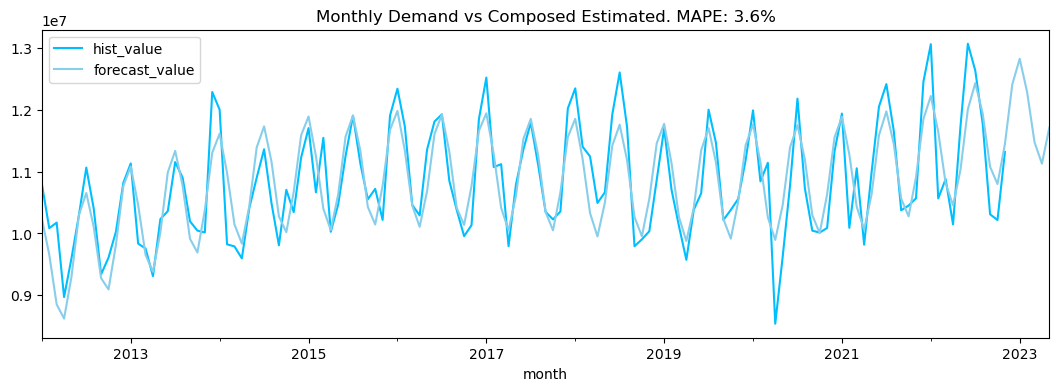

In [83]:
poly_degree=3
df_forecast, mape = train_compose(df_mdemand, poly_degree, future_steps)
plot_df(df_forecast, time_since=df_forecast.month.min(), time_until=df_forecast.month.max(), time_col='month'
    , left_feat_lst=['hist_value', 'forecast_value']
    , right_feat_lst=[]
    , title="Monthly Demand vs Composed Estimated. MAPE: " + str(round(mape, 1)) + "%", xposition=[], yposition=[]
    , fig_size=[13, 4], return_df=False, left_feat_markers=None, right_feat_markers=None, xlim=None, ylim=None, texts=None)

In [84]:
model_id = 'composed'
experiment_date = datetime.now().date()
presist_experiment(model_id, experiment_date, mape, df_forecast, cnxn, cursor, verbose=True)

1 rows inserted to the cammesa_db.experiments table
INFO presist_experiment experiment composed inserted Ok on DB. 2023-01-10
137 rows inserted to the cammesa_db.experiments_detail table
INFO presist_experiment experiment details composed inserted Ok on DB. 


### ARIMA

In [17]:
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima.model.ARIMA.html
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings("ignore", category=Warning)

In [18]:
def train_arima(df_mdemand, p, d, q, freq='MS', future_steps=12):
    df_ = df_mdemand.copy()
    # Add time index:
    if df_.index.name != 'month':
        df_.set_index('month', inplace=True)
    # fit model
    model = ARIMA(df_['hist_value'], order=(p, d, q), freq='MS') # MS: month start
    model_fit = model.fit()
    df_estimated = df_mdemand.copy()
    df_estimated['forecast_value'] = model_fit.predict(start=df_.index.min(), end=df_.index.max()).values

    #calculating mean absolute error and root mean squared error for model evaluation
    mape = mean_absolute_percentage_error(df_estimated[df_estimated.forecast_value.notna()].hist_value.values
                                    , df_estimated[df_estimated.forecast_value.notna()].forecast_value.values) * 100

    df_future = pd.date_range(df_mdemand.month.max() + relativedelta(months=+1), periods=future_steps, freq='MS').to_frame()
    df_future.reset_index(drop=True, inplace=True)
    df_future['hist_value'] = None
    df_future['forecast_value'] = model_fit.forecast(steps=future_steps).values
    df_future.columns = ['month', 'hist_value', 'forecast_value']

    df_forecast = pd.concat([df_estimated, df_future])
    return df_forecast, mape

nan

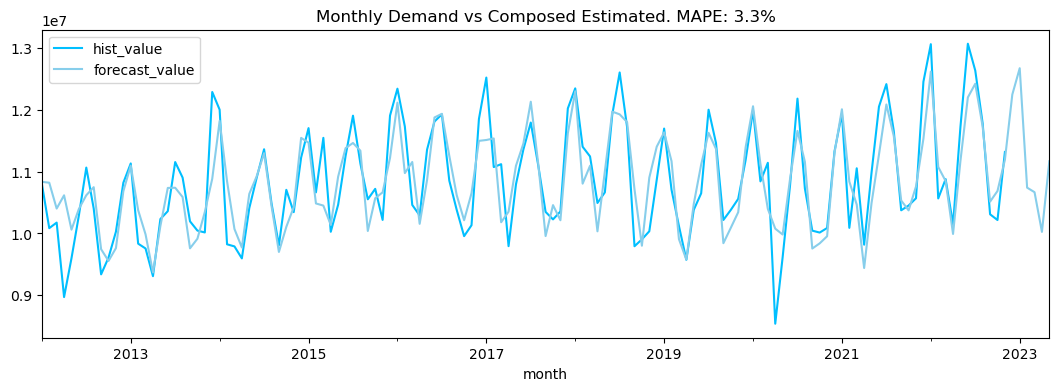

In [85]:
p, d, q = 12, 0, 6
df_forecast, mape = train_arima(df_mdemand, p, d, q, freq='MS', future_steps=future_steps)
plot_df(df_forecast, time_since=df_forecast.month.min(), time_until=df_forecast.month.max(), time_col='month'
    , left_feat_lst=['hist_value', 'forecast_value']
    , right_feat_lst=[]
    , title="Monthly Demand vs Composed Estimated. MAPE: " + str(round(mape, 1)) + "%", xposition=[], yposition=[]
    , fig_size=[13, 4], return_df=False, left_feat_markers=None, right_feat_markers=None, xlim=None, ylim=None, texts=None)

In [86]:
model_id = 'arima1206'
experiment_date = datetime.now().date()
presist_experiment(model_id, experiment_date, mape, df_forecast, cnxn, cursor, verbose=True)

1 rows inserted to the cammesa_db.experiments table
INFO presist_experiment experiment arima1206 inserted Ok on DB. 2023-01-10
137 rows inserted to the cammesa_db.experiments_detail table
INFO presist_experiment experiment details arima1206 inserted Ok on DB. 


nan

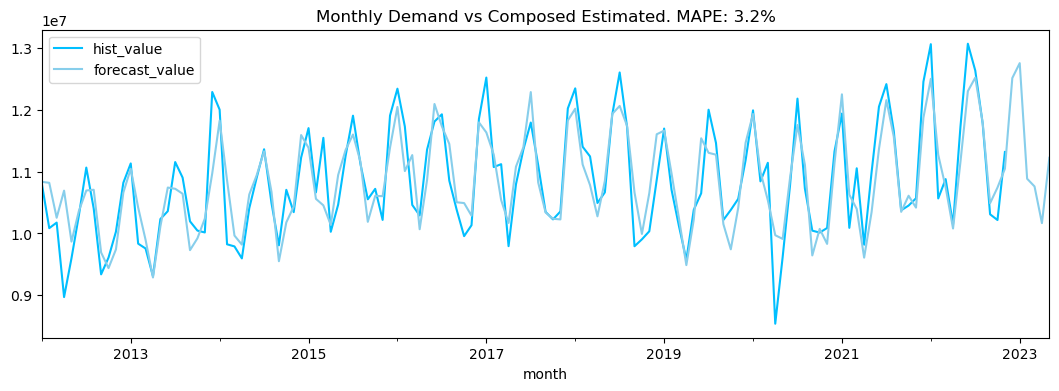

In [87]:
p, d, q = 9, 0, 12
df_forecast, mape = train_arima(df_mdemand, p, d, q, freq='MS', future_steps=future_steps)
plot_df(df_forecast, time_since=df_forecast.month.min(), time_until=df_forecast.month.max(), time_col='month'
    , left_feat_lst=['hist_value', 'forecast_value']
    , right_feat_lst=[]
    , title="Monthly Demand vs Composed Estimated. MAPE: " + str(round(mape, 1)) + "%", xposition=[], yposition=[]
    , fig_size=[13, 4], return_df=False, left_feat_markers=None, right_feat_markers=None, xlim=None, ylim=None, texts=None)

In [88]:
model_id = 'arima9012'
experiment_date = datetime.now().date()
presist_experiment(model_id, experiment_date, mape, df_forecast, cnxn, cursor, verbose=True)

1 rows inserted to the cammesa_db.experiments table
INFO presist_experiment experiment arima9012 inserted Ok on DB. 2023-01-10
137 rows inserted to the cammesa_db.experiments_detail table
INFO presist_experiment experiment details arima9012 inserted Ok on DB. 


### Prophet

In [23]:
# SIN EMBARGO, finalmente funcionó con sólo:
# conda install -c conda-forge prophet

from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [24]:
def train_prophet(df_mdemand, future_steps=12):
    df_ = df_mdemand.copy()
    # Add time index:
    if df_.index.name == 'month':
        df_.reset_index(drop=False, inplace=True)
    # Prophet  imposes the strict condition that the input columns must be named as ds (the time column) and y (the metric column).
    df_.rename(columns={'month': 'ds', 'hist_value': 'y'}, inplace=True)
    # Declare model, set the uncertainty interval to 95% (the Prophet default is 80%)
    model = Prophet(interval_width=0.95)#, stan_backend='CMDSTANPY')
    # Fit to data
    model.fit(df_)

    # Predict includes prediction for the whole time line    
    # In Python, the frequency can be anything from the pandas list of frequency strings here: 
    # https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases .
    future_dates = model.make_future_dataframe(periods=future_steps, freq='MS')
    forecast = model.predict(future_dates)
    df_forecast = df_.merge(right=forecast[['ds', 'yhat']], on='ds', how='outer')
    df_forecast.columns = ['month', 'hist_value', 'forecast_value']

    # Calculate mean absolute error and root mean squared error for model evaluation
    mape = mean_absolute_percentage_error(df_forecast[df_forecast.hist_value.notna()].hist_value.values
                                    , df_forecast[df_forecast.hist_value.notna()].forecast_value.values) * 100
    return df_forecast, mape

21:15:59 - cmdstanpy - INFO - Chain [1] start processing
21:15:59 - cmdstanpy - INFO - Chain [1] done processing


nan

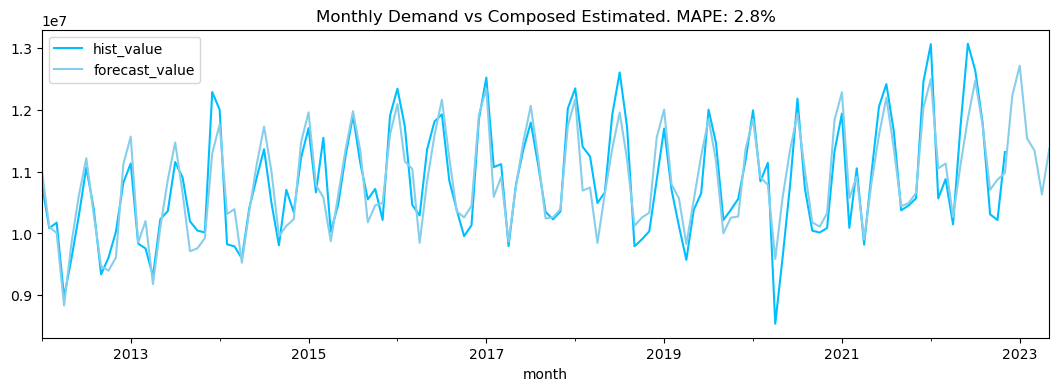

In [89]:
df_forecast, mape = train_prophet(df_mdemand, future_steps=6)
plot_df(df_forecast, time_since=df_forecast.month.min(), time_until=df_forecast.month.max(), time_col='month'
    , left_feat_lst=['hist_value', 'forecast_value']
    , right_feat_lst=[]
    , title="Monthly Demand vs Composed Estimated. MAPE: " + str(round(mape, 1)) + "%", xposition=[], yposition=[]
    , fig_size=[13, 4], return_df=False, left_feat_markers=None, right_feat_markers=None, xlim=None, ylim=None, texts=None)

In [90]:
model_id = 'prophet'
experiment_date = datetime.now().date()
presist_experiment(model_id, experiment_date, mape, df_forecast, cnxn, cursor, verbose=True)

1 rows inserted to the cammesa_db.experiments table
INFO presist_experiment experiment prophet inserted Ok on DB. 2023-01-10
137 rows inserted to the cammesa_db.experiments_detail table
INFO presist_experiment experiment details prophet inserted Ok on DB. 


### ANN FNN

In [27]:
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense

In [28]:
def train_fnn(df_demand, look_back=24, hidden_nodes=12, output_nodes=1, future_steps=6, epochs=100, batch_size=10):
    # FNN autorregresive
    df_ = df_mdemand.copy()
    df_.set_index('month', inplace=True)

    # Normalization: One reason this is important is because the features are multiplied by the model weights. 
    # So, the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(df_)
    data = scaler.transform(df_) # Returns an array!!!

    # preprocess data:
    data = np.array(data)[:, 0] # transforms the array of arrays len(1) (matrix) in an array
    X_train = []
    y_train = []
    for i in range(data.shape[0]-look_back): # does not include last "look_back" records
        x = data[i:look_back+i][::-1] # For each step, takes the last "look_back" timesteps and returns them backwards:
        y = data[look_back+i] # takes the n'th target
        X_train.append(list(x))
        y_train.append(y)
    # list[<start>:<stop>:<step>]: So, when you do a[::-1], it starts from the end towards the first taking each element. 
    # So it reverses a.
    #input_seq_for_test = data[i+1:look_back+i+1][::-1] # the last "look_back" records
    if type(X_train) == list:
        X_train = np.array(X_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))
    y_train = np.reshape(y_train, (len(y_train), 1))

    # Create Model
    input_nodes = look_back
    model = Sequential()
    model.add(Dense(int(hidden_nodes), input_dim=int(input_nodes)))
    model.add(Dense(int(output_nodes)))
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Fit model to data
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=True)

    # Calculate MAPE
    predicted = model.predict(X_train, verbose=0)
    predicted = np.reshape(scaler.inverse_transform(predicted), (len(predicted)))
    lst = [None] * look_back # First look_back positions have no predicted values
    df_.reset_index(drop=False, inplace=True)
    df_['forecast_value'] = np.concatenate((np.array(lst), predicted))
    mape = round(mean_absolute_percentage_error(df_[df_.forecast_value.notna()].hist_value
                    , df_[df_.forecast_value.notna()].forecast_value) * 100, 2)

    input_sequence = data[i+1:look_back+i+1][::-1] # the last "look_back" records
    input_sequence = np.reshape(input_sequence, (1, len(input_sequence)))
    forecasted_values = []
    for i in range(future_steps):
        forecasted_value = model.predict(input_sequence, verbose=0)
        forecasted_values.append(forecasted_value[0][0])
        input_sequence[0] = np.append(forecasted_value, input_sequence[0][:-1]) # replaces current input_sequence starting with 
        # recently forecasted value and the rest of the sequence shifted 1 to the right (remember, the data is backwards)
        # and you add the last forecasted value at the beggining. This is the new window to forecast
    forecasted_values = list(scaler.inverse_transform([forecasted_values])[0])

    # Build final dataframe
    df_forecast =  (pd.date_range(df_.month.min(), df_.month.max()+relativedelta(months=future_steps), freq='MS')).to_frame()
    df_forecast.columns = ['month']
    df_forecast.reset_index(drop=True, inplace=True)
    df_forecast = df_forecast.merge(right=df_, on='month', how='left')
    df_forecast['forecast_value'] = np.concatenate((np.array(lst), predicted, forecasted_values))
    df_forecast
    return df_forecast, mape

nan

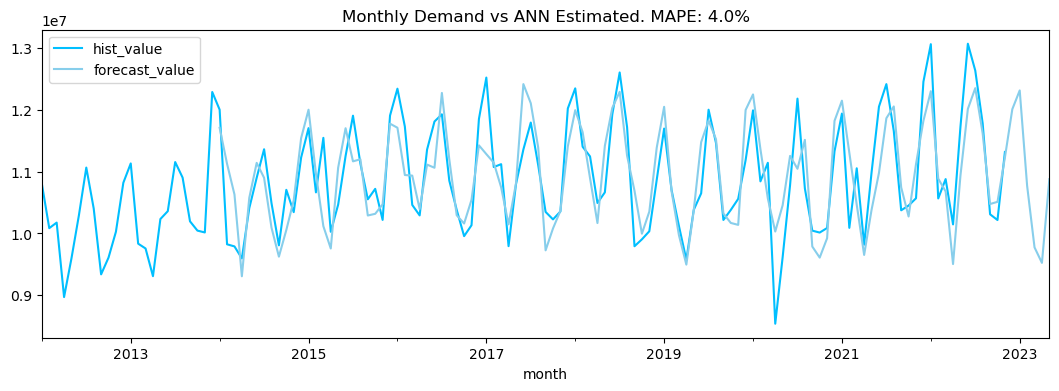

In [92]:
look_back, hidden_nodes, output_nodes, epochs, batch_size, future_steps = 18, 3, 1, 200, 1, 6
look_back, hidden_nodes, output_nodes, epochs, batch_size, future_steps = 24, 12, 1, 100, 10, 6
df_forecast, mape = train_fnn(df_mdemand, look_back=24, hidden_nodes=12, output_nodes=1, future_steps=6, epochs=100, batch_size=10)
plot_df(df_forecast, time_since=df_forecast.month.min(), time_until=df_forecast.month.max(), time_col='month'
    , left_feat_lst=['hist_value', 'forecast_value']
    , right_feat_lst=[]
    , title="Monthly Demand vs ANN Estimated. MAPE: " + str(round(mape, 1)) + "%", xposition=[], yposition=[]
    , fig_size=[13, 4], return_df=False, left_feat_markers=None, right_feat_markers=None, xlim=None, ylim=None, texts=None)

In [93]:
model_id = 'fnn'
experiment_date = datetime.now().date()
presist_experiment(model_id, experiment_date, mape, df_forecast, cnxn, cursor, verbose=True)

1 rows inserted to the cammesa_db.experiments table
INFO presist_experiment experiment fnn inserted Ok on DB. 2023-01-10
137 rows inserted to the cammesa_db.experiments_detail table
INFO presist_experiment experiment details fnn inserted Ok on DB. 


### Timed Lagged NN

In [32]:
def train_tlnn(df_mdemand, look_back=24, long_lag_step=12, max_step=60, hidden_nodes=12, output_nodes=1, epochs=1000, batch_size=32
    , extra_lag = True, future_steps = 6):
    df_ = df_mdemand.copy()
    df_.set_index('month', inplace=True)
    # Normalization: One reason this is important is because the features are multiplied by the model weights. 
    # So, the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(df_)
    data = scaler.transform(df_) # Returns an array!!!

    # preprocess data:
    #if not adding extra lag features adjust max_step and look_back to aling
    if not extra_lag:
        max_step=look_back
        look_back+=1    
    # Option backwards
    X, y = list(), list()
    idx=0
    for i in range(len(data)-1, idx, -1):
        # find the end of this pattern
        end_ix = i - max_step
        # check if we are outside the dataset
        if end_ix < 0:
            break
        look_back_slice = [x for x in range(i-1, i-1-look_back, -1)]
        long_lag_slice = [y for y in range(i-((int(look_back/long_lag_step)+1)*long_lag_step), i-1-max_step, -long_lag_step)]
        slices = list(set(look_back_slice + long_lag_slice))
        
        slices.sort(reverse=True)
        # gather input and output parts of the pattern
        seq_x = data[slices, :]
        seq_y = data[i, :] 
        X.append(seq_x)
        y.append(seq_y)
        
    # Reverse order, because we are processing the original data backwards
    X_train = np.array(X)[::-1]
    y_train = np.array(y)[::-1]
    #if type(X_train) == list:
    #    X_train = np.array(X_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))
    y_train = np.reshape(y_train, (len(y_train), 1))

    # Create Model
    input_nodes = look_back + (max_step - ((int(look_back/long_lag_step))*long_lag_step))/long_lag_step
    model = Sequential()
    model.add(Dense(int(hidden_nodes), input_dim=int(input_nodes)))
    model.add(Dense(int(output_nodes)))
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Fit model to data
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=True)

    # Calculate MAPE
    predicted = model.predict(X_train, verbose=0)
    predicted = np.reshape(scaler.inverse_transform(predicted), (len(predicted)))
    lst = [None] * max_step # First max_step positions have no predicted values, because are used to predict
    df_.reset_index(drop=False, inplace=True)
    df_['forecast_value'] = np.concatenate((np.array(lst), predicted))
    mape = round(mean_absolute_percentage_error(df_[df_.forecast_value.notna()].hist_value
                    , df_[df_.forecast_value.notna()].forecast_value) * 100, 2)

    # Forecast
    forecasted_values = []
    for idx in range(0, future_steps, 1):
        i = len(data)
        end_ix = i - max_step
        #create a list with the indexes we want to include in each sample  check if we are outside the dataset
        if end_ix < 0:
            break
        look_back_slice = [x for x in range(i-1, i-1-look_back, -1)]
        long_lag_slice = [y for y in range(i-((int(look_back/long_lag_step)+1)*long_lag_step), i-1-max_step, -long_lag_step)]
        slices = list(set(look_back_slice + long_lag_slice))
        slices.sort(reverse=True)
        # gather input and output parts of the pattern
        input_sequence = data[slices, :]
        input_sequence = np.reshape(input_sequence, (1, input_sequence.shape[0]))

        forecasted_value = model.predict(input_sequence, verbose=0)
        forecasted_values.append(forecasted_value[0][0])        
        data = np.append(data, forecasted_value, axis=0)
    forecasted_values = list(scaler.inverse_transform([forecasted_values])[0])
    # Build final dataframe
    df_forecast =  (pd.date_range(df_.month.min(), df_.month.max()+relativedelta(months=future_steps), freq='MS')).to_frame()
    df_forecast.columns = ['month']
    df_forecast.reset_index(drop=True, inplace=True)
    df_forecast = df_forecast.merge(right=df_, on='month', how='left')
    df_forecast['forecast_value'] = np.concatenate((np.array(lst), predicted, forecasted_values))
    df_forecast
    return df_forecast, mape

nan

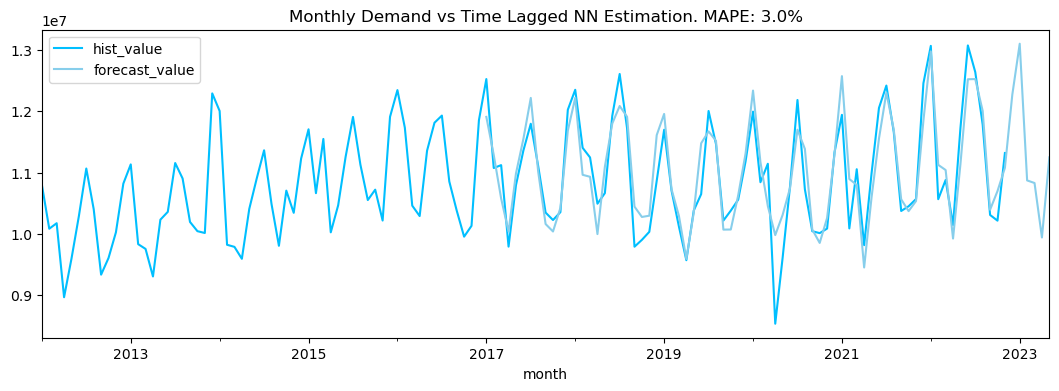

In [94]:
# Model
look_back = 24  # 1 year
long_lag_step = 12 # lags every 1 year, the same month
max_step = 60 # 2 years
hidden_nodes = 12
output_nodes = 1
epochs = 1000 # 2000 ~ 1:20 m
batch_size = 32 # when you reduce this value, the time increases, because the batch size is a hyperparameter of gradient descent 
# that controls the number of training samples to work through before the model’s internal parameters are updated.
extra_lag = True
future_steps = 6
df_forecast, mape = train_tlnn(df_mdemand, look_back=24, long_lag_step=12, max_step=60, hidden_nodes=12, output_nodes=1, epochs=1000
    , batch_size=32, extra_lag = True, future_steps = 6)
plot_df(df_forecast, time_since=df_forecast.month.min(), time_until=df_forecast.month.max(), time_col='month'
    , left_feat_lst=['hist_value', 'forecast_value']
    , right_feat_lst=[]
    , title="Monthly Demand vs Time Lagged NN Estimation. MAPE: " + str(round(mape, 1)) + "%", xposition=[], yposition=[]
    , fig_size=[13, 4], return_df=False, left_feat_markers=None, right_feat_markers=None, xlim=None, ylim=None, texts=None)

In [95]:
model_id = 'tlnn'
experiment_date = datetime.now().date()
presist_experiment(model_id, experiment_date, mape, df_forecast, cnxn, cursor, verbose=True)

1 rows inserted to the cammesa_db.experiments table
INFO presist_experiment experiment tlnn inserted Ok on DB. 2023-01-10
137 rows inserted to the cammesa_db.experiments_detail table
INFO presist_experiment experiment details tlnn inserted Ok on DB. 


### LSTM

In [99]:
from keras.layers import LSTM
from keras.layers import Bidirectional

In [100]:
def train_lstm(df_mdemand, n_features = 1, look_back=12, hidden_nodes=96, output_nodes=1, epochs=1000, batch_size=32, future_steps = 6):
    df_ = df_mdemand.copy()
    df_.set_index('month', inplace=True)
    # Normalization: One reason this is important is because the features are multiplied by the model weights. 
    # So, the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(df_)
    data = scaler.transform(df_) # Returns an array!!!

    # preprocess data:
    data_ = np.array(data)[:, 0]
    X_train = []
    y_train = []
    for i in range(data_.shape[0]-look_back):
        slice = [j for j in range(i,look_back+i)][::-1]
        x = data_[i:look_back+i][::-1]
        y = data_[look_back+i]
        X_train.append(list(x))
        y_train.append(y)    
    if type(X_train) == list:
        X_train = np.array(X_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], n_features))
    #y_train = np.reshape(y_train, (len(y_train), 1))
    y_train = np.array(y_train)

    # Create Model
    model = Sequential()
    model.add(LSTM(hidden_nodes, activation='relu', input_shape=(look_back, n_features)))
    model.add(Dense(output_nodes))
    # Adam version of stochastic gradient descent
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=epochs, verbose=0)

    # Calculate MAPE
    predicted = model.predict(X_train, verbose=0)
    predicted = np.reshape(scaler.inverse_transform(predicted), (len(predicted)))
    lst = [None] * look_back # First look_back positions have no predicted values, because are used to predict
    df_.reset_index(drop=False, inplace=True)
    df_['forecast_value'] = np.concatenate((np.array(lst), predicted))
    mape = round(mean_absolute_percentage_error(df_[df_.forecast_value.notna()].hist_value
                    , df_[df_.forecast_value.notna()].forecast_value) * 100, 2)

    # Forecast
    forecasted_values = []
    for idx in range(0, future_steps, 1):
        i = len(data)
        slice = [j for j in range(i-look_back,i)]
        # gather input and output parts of the pattern
        input_sequence = data[slice, :][::-1]
        input_sequence = np.reshape(input_sequence, (1, input_sequence.shape[0], n_features))
        forecasted_value = model.predict(input_sequence, verbose=0)
        forecasted_values.append(forecasted_value[0][0])
            
        data = np.append(data, forecasted_value, axis=0)
    forecasted_values = scaler.inverse_transform([forecasted_values])[0]

    # Build final dataframe
    df_forecast =  (pd.date_range(df_.month.min(), df_.month.max()+relativedelta(months=future_steps), freq='MS')).to_frame()
    df_forecast.columns = ['month']
    df_forecast.reset_index(drop=True, inplace=True)
    df_forecast = df_forecast.merge(right=df_, on='month', how='left')
    df_forecast['forecast_value'] = np.concatenate((np.array(lst), predicted, forecasted_values))
    df_forecast
    return df_forecast, mape

nan

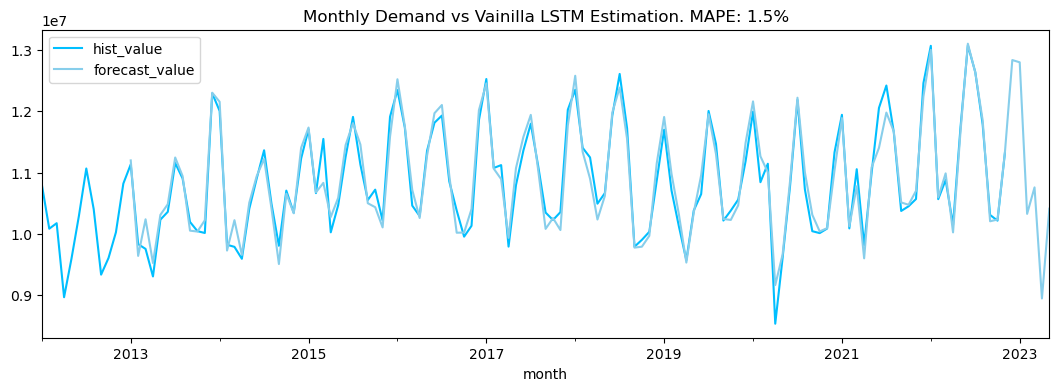

In [102]:
# Model
n_features = 1 # Univariate forcasting
look_back = 12  # 1 year
hidden_nodes = 96
output_nodes = 1
epochs = 1000 # 2000 ~ 1:20 m
batch_size = 32 # when you reduce this value, the time increases, because the batch size is a hyperparameter of gradient descent 
# that controls the number of training samples to work through before the model’s internal parameters are updated.
future_steps = 6

df_forecast, mape = train_lstm(df_mdemand, n_features = 1, look_back=12, hidden_nodes=96, output_nodes=1, epochs=1000, batch_size=32
    , future_steps = 6)
plot_df(df_forecast, time_since=df_forecast.month.min(), time_until=df_forecast.month.max(), time_col='month'
    , left_feat_lst=['hist_value', 'forecast_value']
    , right_feat_lst=[]
    , title="Monthly Demand vs Vainilla LSTM Estimation. MAPE: " + str(round(mape, 1)) + "%", xposition=[], yposition=[]
    , fig_size=[13, 4], return_df=False, left_feat_markers=None, right_feat_markers=None, xlim=None, ylim=None, texts=None)

In [103]:
model_id = 'lstm_vai'
experiment_date = datetime.now().date()
presist_experiment(model_id, experiment_date, mape, df_forecast, cnxn, cursor, verbose=True)

1 rows inserted to the cammesa_db.experiments table
INFO presist_experiment experiment lstm_vai inserted Ok on DB. 2023-01-10
137 rows inserted to the cammesa_db.experiments_detail table
INFO presist_experiment experiment details lstm_vai inserted Ok on DB. 


### Stacked LSTM

In [104]:
def train_stacked_lstm(df_mdemand, n_features = 1, look_back=12, hidden_nodes=96, output_nodes=1, epochs=1000, batch_size=32, future_steps = 6):
    df_ = df_mdemand.copy()
    df_.set_index('month', inplace=True)
    # Normalization: One reason this is important is because the features are multiplied by the model weights. 
    # So, the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(df_)
    data = scaler.transform(df_) # Returns an array!!!

    # preprocess data:
    data_ = np.array(data)[:, 0]
    X_train = []
    y_train = []
    for i in range(data_.shape[0]-look_back):
        slice = [j for j in range(i,look_back+i)][::-1]
        x = data_[i:look_back+i][::-1]
        y = data_[look_back+i]
        X_train.append(list(x))
        y_train.append(y)    
    if type(X_train) == list:
        X_train = np.array(X_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], n_features))
    #y_train = np.reshape(y_train, (len(y_train), 1))
    y_train = np.array(y_train)

    # Create Model
    model = Sequential()
    model.add(LSTM(hidden_nodes, activation='relu', return_sequences=True, input_shape=(look_back, n_features)))
    model.add(LSTM(int(hidden_nodes/2), activation='relu', input_shape=(look_back, n_features)))
    model.add(Dense(output_nodes))
    # Adam version of stochastic gradient descent
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=epochs, verbose=0)

    # Calculate MAPE
    predicted = model.predict(X_train, verbose=0)
    predicted = np.reshape(scaler.inverse_transform(predicted), (len(predicted)))
    lst = [None] * look_back # First look_back positions have no predicted values, because are used to predict
    df_.reset_index(drop=False, inplace=True)
    df_['forecast_value'] = np.concatenate((np.array(lst), predicted))
    mape = round(mean_absolute_percentage_error(df_[df_.forecast_value.notna()].hist_value
                    , df_[df_.forecast_value.notna()].forecast_value) * 100, 2)

    # Forecast
    forecasted_values = []
    for idx in range(0, future_steps, 1):
        i = len(data)
        slice = [j for j in range(i-look_back,i)]
        # gather input and output parts of the pattern
        input_sequence = data[slice, :][::-1]
        input_sequence = np.reshape(input_sequence, (1, input_sequence.shape[0], n_features))
        forecasted_value = model.predict(input_sequence, verbose=0)
        forecasted_values.append(forecasted_value[0][0])
            
        data = np.append(data, forecasted_value, axis=0)
    forecasted_values = scaler.inverse_transform([forecasted_values])[0]

    # Build final dataframe
    df_forecast =  (pd.date_range(df_.month.min(), df_.month.max()+relativedelta(months=future_steps), freq='MS')).to_frame()
    df_forecast.columns = ['month']
    df_forecast.reset_index(drop=True, inplace=True)
    df_forecast = df_forecast.merge(right=df_, on='month', how='left')
    df_forecast['forecast_value'] = np.concatenate((np.array(lst), predicted, forecasted_values))
    df_forecast
    return df_forecast, mape

nan

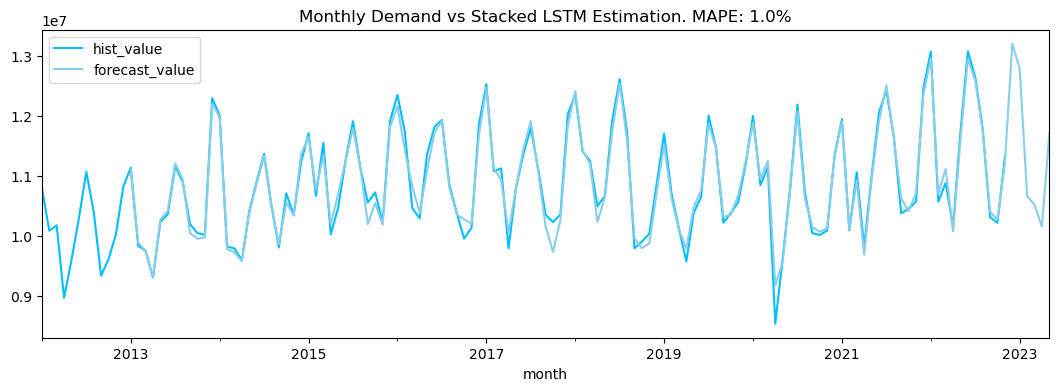

In [105]:
# Model
n_features = 1 # Univariate forcasting
look_back = 12  # 1 year
hidden_nodes = 96
output_nodes = 1
epochs = 1000 # 2000 ~ 1:20 m
batch_size = 32 # when you reduce this value, the time increases, because the batch size is a hyperparameter of gradient descent 
# that controls the number of training samples to work through before the model’s internal parameters are updated.
future_steps = 6

df_forecast, mape = train_stacked_lstm(df_mdemand, n_features = 1, look_back=12, hidden_nodes=96, output_nodes=1, epochs=1000, batch_size=32
    , future_steps = 6)
plot_df(df_forecast, time_since=df_forecast.month.min(), time_until=df_forecast.month.max(), time_col='month'
    , left_feat_lst=['hist_value', 'forecast_value']
    , right_feat_lst=[]
    , title="Monthly Demand vs Stacked LSTM Estimation. MAPE: " + str(round(mape, 1)) + "%", xposition=[], yposition=[]
    , fig_size=[13, 4], return_df=False, left_feat_markers=None, right_feat_markers=None, xlim=None, ylim=None, texts=None)

In [106]:
model_id = 'lstm_stk'
experiment_date = datetime.now().date()
presist_experiment(model_id, experiment_date, mape, df_forecast, cnxn, cursor, verbose=True)

1 rows inserted to the cammesa_db.experiments table
INFO presist_experiment experiment lstm_stk inserted Ok on DB. 2023-01-10
137 rows inserted to the cammesa_db.experiments_detail table
INFO presist_experiment experiment details lstm_stk inserted Ok on DB. 


### CNN

In [107]:
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

from tensorflow.keras import regularizers

In [108]:
def train_cnn(df_mdemand, n_features = 1, look_back = 12, conv_filter = 64, conv_kernel_size = 4, hidden_nodes = 48,
    output_nodes = 1, epochs = 1000, batch_size = 32, future_steps = 6):
    df_ = df_mdemand.copy()
    df_.set_index('month', inplace=True)
    # Normalization: One reason this is important is because the features are multiplied by the model weights. 
    # So, the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(df_)
    data = scaler.transform(df_) # Returns an array!!!

    # preprocess data:
    data_ = np.array(data)[:, 0]
    X_train = []
    y_train = []
    for i in range(data_.shape[0]-look_back):
        slice = [j for j in range(i,look_back+i)][::-1]
        x = data_[i:look_back+i][::-1]
        y = data_[look_back+i]
        X_train.append(list(x))
        y_train.append(y)    
    if type(X_train) == list:
        X_train = np.array(X_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], n_features))
    y_train = np.array(y_train)

    # Create Model
    model = Sequential()
    model.add(Conv1D(filters=conv_filter, kernel_size=conv_kernel_size, activation='relu', input_shape=(look_back, n_features)
                    , kernel_regularizer=regularizers.l2(l=0.01)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(units=hidden_nodes, activation='relu'))
    model.add(Dense(output_nodes))
    # Adam version of stochastic gradient descent
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=epochs, verbose=0)

    # Calculate MAPE
    predicted = model.predict(X_train, verbose=0)
    predicted = np.reshape(scaler.inverse_transform(predicted), (len(predicted)))
    lst = [None] * look_back # First look_back positions have no predicted values, because are used to predict
    df_.reset_index(drop=False, inplace=True)
    df_['forecast_value'] = np.concatenate((np.array(lst), predicted))
    mape = round(mean_absolute_percentage_error(df_[df_.forecast_value.notna()].hist_value
                    , df_[df_.forecast_value.notna()].forecast_value) * 100, 2)

    # Forecast
    forecasted_values = []
    for idx in range(0, future_steps, 1):
        i = len(data)
        slice = [j for j in range(i-look_back,i)]
        # gather input and output parts of the pattern
        input_sequence = data[slice, :][::-1]
        input_sequence = np.reshape(input_sequence, (1, input_sequence.shape[0], n_features))
        forecasted_value = model.predict(input_sequence, verbose=0)
        forecasted_values.append(forecasted_value[0][0])
            
        data = np.append(data, forecasted_value, axis=0)
    forecasted_values = scaler.inverse_transform([forecasted_values])[0]

    # Build final dataframe
    df_forecast =  (pd.date_range(df_.month.min(), df_.month.max()+relativedelta(months=future_steps), freq='MS')).to_frame()
    df_forecast.columns = ['month']
    df_forecast.reset_index(drop=True, inplace=True)
    df_forecast = df_forecast.merge(right=df_, on='month', how='left')
    df_forecast['forecast_value'] = np.concatenate((np.array(lst), predicted, forecasted_values))
    df_forecast
    return df_forecast, mape

nan

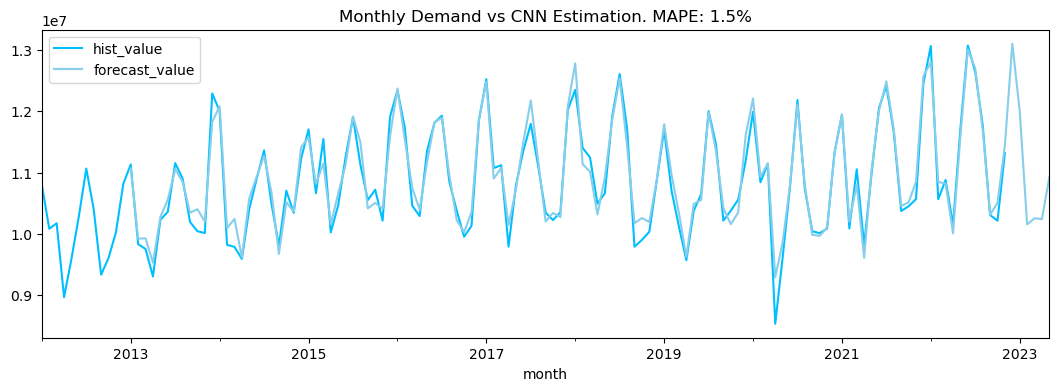

In [110]:
n_features = 1 # Univariate forcasting
look_back = 12  # 1 year
conv_filter = 64 # number of features to extract 96 - 64 - Best practice: less filter at the input, more in deeper layers.
conv_kernel_size = 4 #dimensions of the convolution window.
hidden_nodes = 48 #48
output_nodes = 1
epochs = 1000
batch_size = 32 # when you reduce this value, the time increases, because the batch size is a hyperparameter of gradient descent 
# that controls the number of training samples to work through before the model’s internal parameters are updated.
future_steps = 6

df_forecast, mape = train_cnn(df_mdemand, n_features=n_features, look_back=look_back, conv_filter=conv_filter
    , conv_kernel_size=conv_kernel_size, hidden_nodes=hidden_nodes, output_nodes=output_nodes, epochs=epochs
    , batch_size=batch_size, future_steps=future_steps)
plot_df(df_forecast, time_since=df_forecast.month.min(), time_until=df_forecast.month.max(), time_col='month'
    , left_feat_lst=['hist_value', 'forecast_value']
    , right_feat_lst=[]
    , title="Monthly Demand vs CNN Estimation. MAPE: " + str(round(mape, 1)) + "%", xposition=[], yposition=[]
    , fig_size=[13, 4], return_df=False, left_feat_markers=None, right_feat_markers=None, xlim=None, ylim=None, texts=None)

In [111]:
model_id = 'cnn'
experiment_date = datetime.now().date()
presist_experiment(model_id, experiment_date, mape, df_forecast, cnxn, cursor, verbose=True)

1 rows inserted to the cammesa_db.experiments table
INFO presist_experiment experiment cnn inserted Ok on DB. 2023-01-10
137 rows inserted to the cammesa_db.experiments_detail table
INFO presist_experiment experiment details cnn inserted Ok on DB. 


In [541]:
df_mdemand.to_csv('mdemand.csv', sep=';', encoding='latin-1', decimal=',')

### SVM Regressor

In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

In [75]:
def train_svr(df_mdemand, n_features = 1, look_back = 12, C=10, gamma=0.1, kernel='poly', epsilon=0.1, future_steps = 6):
    df_ = df_mdemand.copy()
    df_.set_index('month', inplace=True)
    # Normalization: One reason this is important is because the features are multiplied by the model weights. 
    # So, the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(df_)
    data = scaler.transform(df_) # Returns an array!!!

    # For the SVR, you transform the input data to be of the form [batch, timesteps]
    # preprocess data:
    data_ = np.array(data)[:, 0]
    X_train = []
    y_train = []
    for i in range(data_.shape[0]-look_back):
        slice = [j for j in range(i,look_back+i)][::-1]
        x = data_[i:look_back+i][::-1]
        y = data_[look_back+i]
        X_train.append(list(x))
        y_train.append(y)    
    if type(X_train) == list:
        X_train = np.array(X_train)
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    # Create Model
    model = SVR(kernel=kernel, gamma=gamma, C=C, epsilon=epsilon)
    model.fit(X_train, y_train)

    # Calculate MAPE
    predicted = model.predict(X_train)
    predicted = np.reshape(scaler.inverse_transform(predicted.reshape(-1,1)), predicted.shape[0])
    lst = [None] * look_back # First look_back positions have no predicted values, because are used to predict
    df_.reset_index(drop=False, inplace=True)
    df_['forecast_value'] = np.concatenate((np.array(lst), predicted))
    mape = round(mean_absolute_percentage_error(df_[df_.forecast_value.notna()].hist_value
                    , df_[df_.forecast_value.notna()].forecast_value) * 100, 2)

    # Forecast
    forecasted_values = []
    for idx in range(0, future_steps, 1):
        i = len(data)
        slice = [j for j in range(i-look_back,i)]
        # gather input and output parts of the pattern
        input_sequence = data[slice, :][::-1]
        input_sequence = input_sequence.reshape(-1, input_sequence.shape[0])
        forecasted_value = model.predict(input_sequence)
        forecasted_values.append(forecasted_value[0])
            
        data = np.append(data, forecasted_value.reshape(-1, 1), axis=0)
    forecasted_values = scaler.inverse_transform([forecasted_values])[0]

    # Build final dataframe
    df_forecast =  (pd.date_range(df_.month.min(), df_.month.max()+relativedelta(months=future_steps), freq='MS')).to_frame()
    df_forecast.columns = ['month']
    df_forecast.reset_index(drop=True, inplace=True)
    df_forecast = df_forecast.merge(right=df_, on='month', how='left')
    df_forecast['forecast_value'] = np.concatenate((np.array(lst), predicted, forecasted_values))
    df_forecast
    return df_forecast, mape

nan

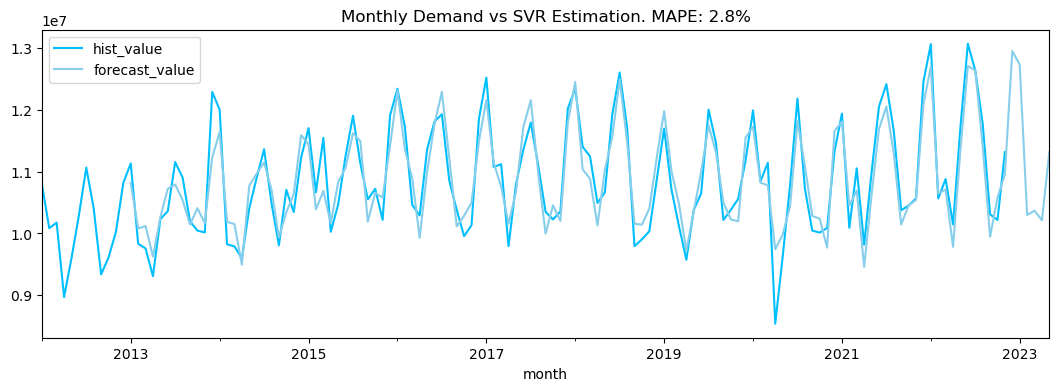

In [112]:
n_features = 1
look_back = 12
future_steps = 6
# Best Params: {'C': 10, 'epsilon': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
# kernel='rbf', gamma=0.5, C=10, epsilon = 0.08
kernel, gamma, C, epsilon= 'rbf', 0.5, 10, 0.08
df_forecast, mape = train_svr(df_mdemand, n_features =n_features, look_back=look_back, C=C, gamma=gamma, kernel=kernel
    , epsilon=epsilon, future_steps=future_steps)
plot_df(df_forecast, time_since=df_forecast.month.min(), time_until=df_forecast.month.max(), time_col='month'
    , left_feat_lst=['hist_value', 'forecast_value']
    , right_feat_lst=[]
    , title="Monthly Demand vs SVR Estimation. MAPE: " + str(round(mape, 1)) + "%", xposition=[], yposition=[]
    , fig_size=[13, 4], return_df=False, left_feat_markers=None, right_feat_markers=None, xlim=None, ylim=None, texts=None)

In [113]:
model_id = 'svr'
experiment_date = datetime.now().date()
presist_experiment(model_id, experiment_date, mape, df_forecast, cnxn, cursor, verbose=True)

1 rows inserted to the cammesa_db.experiments table
INFO presist_experiment experiment svr inserted Ok on DB. 2023-01-10
137 rows inserted to the cammesa_db.experiments_detail table
INFO presist_experiment experiment details svr inserted Ok on DB. 


In [44]:
df_mdemand = df_monthly_demand.copy()
df_mdemand.set_index('month', inplace=True)
# Data Scaled
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(df_mdemand)
data = scaler.transform(df_mdemand)

# For the SVR, you transform the input data to be of the form [batch, timesteps]
look_back = 12
n_features = 1
# preprocess data:
data_ = np.array(data)[:, 0]
X_train = []
y_train = []
for i in range(data_.shape[0]-look_back):
    slice = [j for j in range(i,look_back+i)][::-1]
    x = data_[i:look_back+i][::-1]
    y = data_[look_back+i]
    X_train.append(list(x))
    y_train.append(y)    
if type(X_train) == list:
    X_train = np.array(X_train)
X_train = np.array(X_train)
y_train = np.array(y_train)

# model
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid'], 'epsilon':[0.08, 0.1, 1.01]}

grid = GridSearchCV(SVR(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)
print('Best Estimator:', grid.best_estimator_)
print('Best Params:', grid.best_params_)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV] END ...........C=0.1, epsilon=0.08, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.1, epsilon=0.08, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.1, epsilon=0.08, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.1, epsilon=0.08, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.1, epsilon=0.08, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.1, epsilon=0.08, gamma=1, kernel=poly; total time=   0.0s
[CV] END ..........C=0.1, epsilon=0.08, gamma=1, kernel=poly; total time=   0.0s
[CV] END ..........C=0.1, epsilon=0.08, gamma=1, kernel=poly; total time=   0.0s
[CV] END ..........C=0.1, epsilon=0.08, gamma=1, kernel=poly; total time=   0.0s
[CV] END ..........C=0.1, epsilon=0.08, gamma=1, kernel=poly; total time=   0.0s
[CV] END .......C=0.1, epsilon=0.08, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .......C=0.1, epsilon=0.08, gamma=1, 

<AxesSubplot:xlabel='date'>

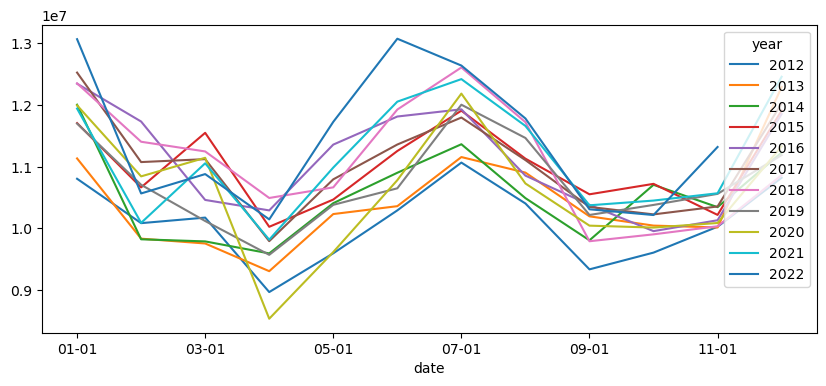

In [131]:
df = df_mdemand.copy()
df['year'] = df.month.dt.year
df['date'] = df.month.dt.strftime('%m-%d')
unstacked = df.set_index(['year', 'date']).hist_value.unstack(-2)
unstacked.plot(figsize=(10, 4))

<AxesSubplot:xlabel='month'>

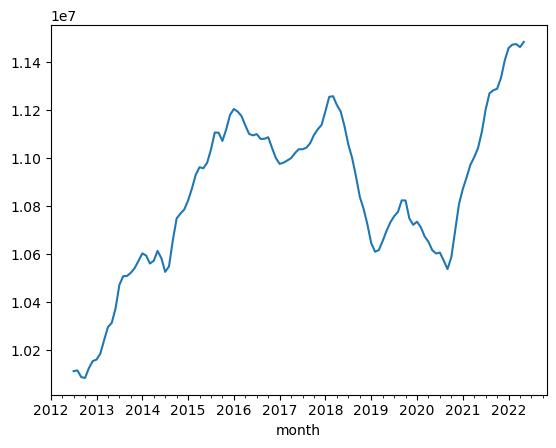

In [129]:
sd_12 = seasonal_decompose(df.set_index('month')[['hist_value']], period=12)
sd_12.trend.plot()

<AxesSubplot:xlabel='month'>

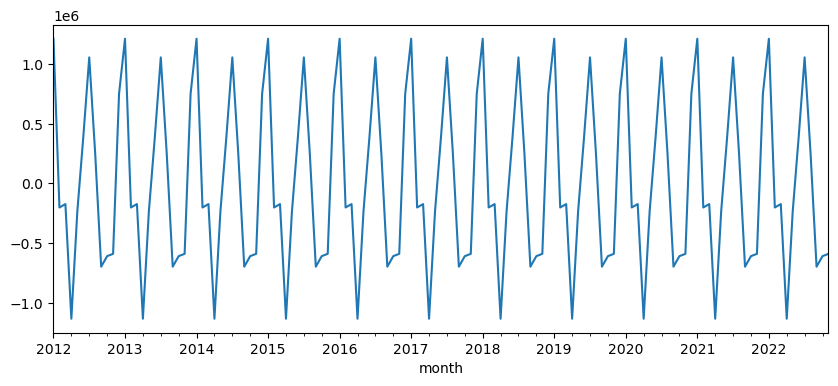

In [132]:
sd_12.seasonal.plot(figsize=(10, 4))